## Training 
1. Open training.ipynb  
2. Executing cells in sequence until "training curve" cell  

> Whether to execute "rotation-based oversampling" cell is up to user. It will expand the training data 4 times.

## Parameters
### Dataset parameter
Change `dataset = dataset_choices[0]` to switch training dataset between `["PolyU","Tongji","MPD_h","MPD_m"]`.  
`val_ratio` is useless, there is no validation code in training process.  
`test_ratio` is to evaluate performance in the source domain. It split the classes not samples, so the test data would need to further divide into registration set and probe set for recognition.  
`shot` is the sample number of registraction set.   
In the training, this three parameters are always the same. For the testing dataset, the `test_ratio` world be set to 0 indicates the registration set and probe set contains all classes.

### Model
There is a "model type" section in the model parameter cell, which contains a few choices like ResNet18, ResNet20, and ResNeSt50.  

### Loss
There is also a "loss functions" section in the model parameter cell contains head and losses. Heas refers to the classifier, whose default is LMCL. Losses compose of classification loss and L2 distance loss, Focal loss and Huber loss is the default.

### Others
`lamb` is the coefficent of L2 distance loss. `Focal loss => 1`, `Center loss => 0.1`  
`lr` is learning rate. While `Center loss = 0.1`, it must not set to larger than `0.001`.  
`mm` is the momentum of `SGDM` optimizer.  
`l2` is the weight decay of optimizers.  



In [1]:
!nvidia-smi

Thu Sep 29 17:39:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.85.02    Driver Version: 510.85.02    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   46C    P3    86W / 320W |    593MiB / 10240MiB |      9%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import os
import time
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.utils.data as data
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import timm
import cv2
import math
import torch.nn.functional as F
from torch.autograd import Variable
import random
plt.style.use("default")
    
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1., amplitude=(0,25)):
        self.std = std
        self.mean = mean
        self.amplitude = amplitude
        
    def __call__(self, img):
        img_arr = np.asarray(img)
        gauss = np.random.normal(self.mean,self.std,img_arr.shape) * random.randint(*self.amplitude)
        img = img_arr + gauss
        img[img>255] = 255
        return Image.fromarray(img.astype("uint8")).convert("RGB")
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

batch_size_train = 32
batch_size_test = 32
image_size = 224
# baseline augmentation
# trainingTransform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.RandomApply([transforms.ColorJitter(brightness=0.5)], p=0.6),
#     transforms.RandomApply([transforms.ColorJitter(contrast=0.5)], p=0.6),
#     # transforms.RandomApply([transforms.ColorJitter(saturation=0.25)], p=0.6),
#     transforms.RandomApply([transforms.ColorJitter(hue=0.25)], p=0.6),
#     transforms.RandomApply([transforms.RandomChoice([transforms.GaussianBlur(1), transforms.GaussianBlur(3), transforms.GaussianBlur(5)])], p=0.6),
#     transforms.RandomAdjustSharpness(1.5, p=0.6),
#     transforms.RandomApply([transforms.RandomResizedCrop(size=image_size, scale=(1.07, 1.14))], p=0.6),
#     transforms.RandomApply([transforms.RandomRotation([-5,5], expand=False)], p=0.6),
#     # transforms.RandomApply([transforms.RandomAffine([-5,5], translate=(0.01, 0.01))], p=0.6),
#     transforms.Resize(image_size),
#     transforms.ToTensor(),
# ])
# testingTransform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Resize(image_size)
# ])


    
# Define space search for training settings
from operator import itemgetter
(brightness,
brightness_p,
contrast,
contrast_p,
# saturation,
# saturation_p,
hue,
hue_p,
# blur_sigma,
# blur_p,
noise_amp,
noise_p,
# rotation_degree,
# rotation_p,
# translatation,
# translatation_p
) = itemgetter(
    'brightness',
    'brightness_probability',
    'contrast',
    'contrast_probability',
    # 'saturation',
    # 'saturation_probability',
    'hue',
    'hue_probability',
    # 'blur_sigma',
    # 'blur_probability',
    'noise_amplitude',
    'noise_probability',
    # 'rotation_degree',
    # 'rotation_probability',
    # 'translatation',
    # 'translatation_probability',
)(torch.load("optuna/best_params-reorder-third-50.pt"))

trainingTransform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomApply([transforms.ColorJitter(brightness=brightness)], p=brightness_p),
    transforms.RandomApply([transforms.ColorJitter(contrast=contrast)], p=contrast_p),
    # transforms.RandomApply([transforms.ColorJitter(saturation=saturation)], p=saturation_p),
    transforms.RandomApply([transforms.ColorJitter(hue=hue)], p=hue_p),
    # transforms.RandomApply([transforms.RandomChoice([transforms.GaussianBlur(3, sigma=(0.1, blur_sigma)), 
    #                                                  transforms.GaussianBlur(5, sigma=(0.1, blur_sigma))])], p=blur_p),
    transforms.RandomApply([AddGaussianNoise(0 , 1, (0, noise_amp))], p=noise_p),
    # transforms.RandomApply([transforms.RandomAffine(degrees=rotation_degree)], p=rotation_p),
    # transforms.RandomApply([transforms.RandomAffine(0, translate=(translatation, translatation))], p=translatation_p),
    transforms.Resize(image_size),
    transforms.ToTensor(),
])
testingTransform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(image_size),
    transforms.ToTensor(),
])

In [7]:
## Tongji dataset
# contain both session of specific indices
class TongjiTrainingDataset(Dataset):
    '''
    all images of selected indices 
    '''
    def __init__(self, root, indices, transforms):
        # 圖片所在的資料夾
        self.root = root
        # 需要的類別編號
        self.indices = indices
        self.transforms = transforms

        self.fnames = []
        self.labels = []
        for c in self.indices:
            for i in range(c*10, c*10+10):
                self.fnames.append(os.path.join(self.root, 'session1/{:05d}.tiff'.format(i+1)))
                self.fnames.append(os.path.join(self.root, 'session2/{:05d}.tiff'.format(i+1)))
                # 左右手視為不同的類別
                self.labels.append(c)
                self.labels.append(c)
        self.labels = torch.Tensor(self.labels).long()

    def __getitem__(self, idx):
        # 利用路徑讀取圖片
        img = Image.open(self.fnames[idx])
        # 將輸入的圖片轉換成符合預訓練模型的形式
        img = self.transforms(img)
        # 補足3個channel
        # img = img.repeat(3,1,1)
        # 圖片相對應的 label
        label = self.labels[idx]
        return img, label
    
    def __len__(self):
        return len(self.fnames)
# contain first session of all indices, and second session of not selected
class TongjiTuningDataset(Dataset):
    '''
    testing set include half of the select indices, and this is the remain(useless)
    '''
    def __init__(self, root, indices, transforms):
        self.root = root
        # 註冊的類別編號
        self.indices = indices
        self.transforms = transforms

        self.fnames = []
        self.labels = []
        for i in range(6000):
            c = int(i/10)
            self.fnames.append(os.path.join(self.root, 'session1/{:05d}.tiff'.format(i+1)))
            self.labels.append(c)
            if c not in self.indices:
                self.fnames.append(os.path.join(self.root, 'session2/{:05d}.tiff'.format(i+1)))
                self.labels.append(c)
        self.labels = torch.Tensor(self.labels).long()

    def __getitem__(self, idx):
        img = Image.open(self.fnames[idx])
        img = self.transforms(img)
        label = self.labels[idx]
        return img, label
    
    def __len__(self):
        return len(self.fnames)

# only contain one session
class TongjiTestingDataset(Dataset):
    '''
    half of the selected indices
    '''
    def __init__(self, root, indices, mode, transforms):
        # 圖片所在的資料夾
        if mode == "probe":
            self.root = os.path.join(root, "session2")
        else:
            self.root = os.path.join(root, "session1")
        # self.root = root
        # 需要的類別編號
        self.indices = indices
        self.transforms = transforms

        self.fnames = []
        self.labels = []
        for c in self.indices:
            for i in range(c*10, c*10+10):
                self.fnames.append(os.path.join(self.root, '{:05d}.tiff'.format(i+1)))
                # 左右手視為不同的類別
                self.labels.append(c)
        self.labels = torch.Tensor(self.labels).long()

    def __getitem__(self, idx):
        # 利用路徑讀取圖片
        img = Image.open(self.fnames[idx])
        # 將輸入的圖片轉換成符合預訓練模型的形式
        img = self.transforms(img)
        # 補足3個channel
        # img = img.repeat(3,1,1)
        # 圖片相對應的 label
        label = self.labels[idx]
        return img, label
    
    def __len__(self):
        return len(self.fnames)
    
# flexibly spliting support set and query set
class TongjiFewShotDataset(Dataset):
    '''
    mode == gallery, get num_samples start from 1 to 20 of each class
    mode == probe, get num_samples start from 20 to 1 of each class
    '''
    def __init__(self, root, indices, num_samples, mode, transforms):
        # 圖片所在的資料夾
        self.root = root
        # 需要的類別編號
        self.indices = indices
        self.transforms = transforms
        if num_samples > 20:
            raise BaseException("Number of samples larger than the limit")
        else:
            self.session1 = 10 if num_samples > 10 else num_samples
            self.session2 = num_samples - self.session1
            if mode == "probe":
                self.session1, self.session2 = self.session2, self.session1
                self.session1 = range(10-self.session1, 10)
                self.session2 = range(10-self.session2, 10)
            else:
                self.session1 = range(self.session1)
                self.session2 = range(self.session2)

        self.fnames = []
        self.labels = []
        for c in self.indices:
            # get images from session1
            for i in self.session1: # [0,1,2,3,4,5,6,7,8,9]
                self.fnames.append(os.path.join(self.root, 'session1/{:05d}.tiff'.format(c*10+i+1)))
                self.labels.append(c)
            # get images from session2
            for i in self.session2: # [0,1,2,3,4,5,6,7,8,9]
                self.fnames.append(os.path.join(self.root, 'session2/{:05d}.tiff'.format(c*10+i+1)))
                self.labels.append(c)
        self.labels = torch.Tensor(self.labels).long()

    def __getitem__(self, idx):
        # 利用路徑讀取圖片
        img = Image.open(self.fnames[idx])
        img = np.asarray(img)
        # 將輸入的圖片轉換成符合預訓練模型的形式
        img = self.transforms(img)
        # 補足3個channel
        # img = img.repeat(3,1,1)
        # 圖片相對應的 label
        label = self.labels[idx]
        return img, label
    
    def __len__(self):
        return len(self.fnames)
    
# flexibly spliting support set and query set
class TongjiRotationCopyDataset(Dataset):
    '''
    mode == gallery, get num_samples start from 1 to 20 of each class
    mode == probe, get num_samples start from 20 to 1 of each class
    '''
    def __init__(self, root, indices, num_samples, mode, transforms):
        # 圖片所在的資料夾
        self.root = root
        # 需要的類別編號
        self.indices = indices
        self.transforms = transforms
        self.num_samples = num_samples
        if num_samples > 20:
            raise BaseException("Number of samples larger than the limit")
        else:
            self.session1 = 10 if num_samples > 10 else num_samples
            self.session2 = num_samples - self.session1
            if mode == "probe":
                self.session1, self.session2 = self.session2, self.session1
                self.session1 = range(10-self.session1, 10)
                self.session2 = range(10-self.session2, 10)
            else:
                self.session1 = range(self.session1)
                self.session2 = range(self.session2)

        self.fnames = []
        self.labels = []
        for c in self.indices:
            # get images from session1
            for i in self.session1: # [0,1,2,3,4,5,6,7,8,9]
                self.fnames.append(os.path.join(self.root, 'session1/{:05d}.tiff'.format(c*10+i+1)))
                self.labels.append(c)
            # get images from session2
            for i in self.session2: # [0,1,2,3,4,5,6,7,8,9]
                self.fnames.append(os.path.join(self.root, 'session2/{:05d}.tiff'.format(c*10+i+1)))
                self.labels.append(c)
        self.labels = torch.Tensor(self.labels).long()

    def __getitem__(self, idx):
        i = idx % (len(self.indices) * self.num_samples)
        quotient = int(idx / (len(self.indices) * self.num_samples))
        img = Image.open(self.fnames[i])
        img = np.asarray(img)
        if quotient > 0:
            img = np.rot90(img, quotient, (0,1)) # will rotate 1,2,3 times
        img = self.transforms(img)
        label = self.labels[i]
        return img, label + 600 * quotient
    
    def __len__(self):
        return len(self.fnames)*4

In [8]:
## PolyU dataset
# contain both session of specific indices
class PolyUTrainingDataset(Dataset):
    '''
    all images of selected indices 
    '''
    def __init__(self, root, indices, transforms):
        # 圖片所在的資料夾
        self.root = root
        # 需要的類別編號
        self.indices = indices
        self.transforms = transforms

        self.fnames = [[],[],[]]  # R,G,B
        self.labels = []
        for c in self.indices:
            for i in range(6):
                self.fnames[0].append(os.path.join(self.root, 'Multispectral_R/{:03d}/1_{:02d}_s.bmp'.format(c+1, i+1)))
                self.fnames[1].append(os.path.join(self.root, 'Multispectral_G/{:03d}/1_{:02d}_s.bmp'.format(c+1, i+1)))
                self.fnames[2].append(os.path.join(self.root, 'Multispectral_B/{:03d}/1_{:02d}_s.bmp'.format(c+1, i+1)))
                self.fnames[0].append(os.path.join(self.root, 'Multispectral_R/{:03d}/2_{:02d}_s.bmp'.format(c+1, i+1)))
                self.fnames[1].append(os.path.join(self.root, 'Multispectral_G/{:03d}/2_{:02d}_s.bmp'.format(c+1, i+1)))
                self.fnames[2].append(os.path.join(self.root, 'Multispectral_B/{:03d}/2_{:02d}_s.bmp'.format(c+1, i+1)))
                # 2 sessions
                self.labels.append(c)
                self.labels.append(c)
        self.labels = torch.Tensor(self.labels).long()

    def __getitem__(self, idx):
        img_R = Image.open(self.fnames[0][idx])
        img_G = Image.open(self.fnames[1][idx])
        img_B = Image.open(self.fnames[2][idx])
        img = np.dstack((img_R,img_G,img_B))
        img = self.transforms(img)
        label = self.labels[idx]
        return img, label
    
    def __len__(self):
        return len(self.labels)
    
# only contain one session
class PolyUTestingDataset(Dataset):
    '''
    half of the selected indices
    '''
    def __init__(self, root, indices, mode, transforms):
        self.root = root
        # 需要的類別編號
        self.indices = indices
        self.transforms = transforms
        # 決定session
        if mode == "probe":
            self.session = 2
        else:
            self.session = 1

        self.fnames = [[],[],[]]  # R,G,B
        self.labels = []
        for c in self.indices:
            for i in range(6):
                self.fnames[0].append(os.path.join(self.root, 'Multispectral_R/{:03d}/{}_{:02d}_s.bmp'.format(c+1, self.session, i+1)))
                self.fnames[1].append(os.path.join(self.root, 'Multispectral_G/{:03d}/{}_{:02d}_s.bmp'.format(c+1, self.session, i+1)))
                self.fnames[2].append(os.path.join(self.root, 'Multispectral_B/{:03d}/{}_{:02d}_s.bmp'.format(c+1, self.session, i+1)))
                self.labels.append(c)
        self.labels = torch.Tensor(self.labels).long()

    def __getitem__(self, idx):
        img_R = Image.open(self.fnames[0][idx])
        img_G = Image.open(self.fnames[1][idx])
        img_B = Image.open(self.fnames[2][idx])
        img = np.dstack((img_R,img_G,img_B))
        img = self.transforms(img)
        label = self.labels[idx]
        return img, label
    
    def __len__(self):
        return len(self.labels)
    
# flexibly spliting support set and query set
class PolyUFewShotDataset(Dataset):
    '''
    mode == gallery, get num_samples start from 1 to 20 of each class
    mode == probe, get num_samples start from 20 to 1 of each class
    '''
    def __init__(self, root, indices, num_samples, mode, transforms):
        self.root = root
        self.indices = indices
        self.transforms = transforms
        if num_samples > 12:
            raise BaseException("Number of samples larger than the limit")
        else:
            session1 = 6 if num_samples > 6 else num_samples
            session2 = num_samples - session1
            if mode == "probe":
                session1, session2 = session2, session1
                self.session1 = range(6-session1, 6)
                self.session2 = range(6-session2, 6)
            else:
                self.session1 = range(session1)
                self.session2 = range(session2)

        self.fnames = []
        self.labels = []
        for c in self.indices:
            # get images from session1
            for i in self.session1:
                fname = []
                for channel in "RGB":
                    fname.append(os.path.join(self.root, 'Multispectral_{}/{:03d}/{}_{:02d}_s.bmp'.format(channel, c+1, 1, i+1)))
                self.fnames.append(fname)
                self.labels.append(c)
            # get images from session2
            for i in self.session2:
                fname = []
                for channel in "RGB":
                    fname.append(os.path.join(self.root, 'Multispectral_{}/{:03d}/{}_{:02d}_s.bmp'.format(channel, c+1, 2, i+1)))
                self.fnames.append(fname)
                self.labels.append(c)
        self.labels = torch.Tensor(self.labels).long()

    def __getitem__(self, idx):
        imgs = []
        for i in self.fnames[idx]:
            imgs.append(Image.open(i))
        img = np.dstack(imgs)
        img = self.transforms(img)
        label = self.labels[idx]
        return img, label
    
    def __len__(self):
        return len(self.fnames)
    
# flexibly spliting support set and query set
class PolyURotationCopyDataset(Dataset):
    '''
    mode == gallery, get num_samples start from 1 to 20 of each class
    mode == probe, get num_samples start from 20 to 1 of each class
    '''
    def __init__(self, root, indices, num_samples, mode, transforms):
        self.root = root
        self.indices = indices
        self.transforms = transforms
        self.num_samples = num_samples
        if num_samples > 12:
            raise BaseException("Number of samples larger than the limit")
        else:
            session1 = 6 if num_samples > 6 else num_samples
            session2 = num_samples - session1
            if mode == "probe":
                session1, session2 = session2, session1
                self.session1 = range(6-session1, 6)
                self.session2 = range(6-session2, 6)
            else:
                self.session1 = range(session1)
                self.session2 = range(session2)

        self.fnames = []
        self.labels = []
        for c in self.indices:
            # get images from session1
            for i in self.session1:
                fname = []
                for channel in "RGB":
                    fname.append(os.path.join(self.root, 'Multispectral_{}/{:03d}/{}_{:02d}_s.bmp'.format(channel, c+1, 1, i+1)))
                self.fnames.append(fname)
                self.labels.append(c)
            # get images from session2
            for i in self.session2:
                fname = []
                for channel in "RGB":
                    fname.append(os.path.join(self.root, 'Multispectral_{}/{:03d}/{}_{:02d}_s.bmp'.format(channel, c+1, 2, i+1)))
                self.fnames.append(fname)
                self.labels.append(c)
        self.labels = torch.Tensor(self.labels).long()

    def __getitem__(self, idx):
        imgs = []
        i = idx % (len(self.indices) * self.num_samples)
        quotient = int(idx / (len(self.indices) * self.num_samples))
        for path in self.fnames[i]:
            imgs.append(Image.open(path))
        img = np.dstack(imgs)
        if quotient > 0:
            img = np.rot90(img, quotient, (0,1)) # will rotate 1,2,3 times
        img = self.transforms(img)
        label = self.labels[i]
        return img, label + 500 * quotient
    
    def __len__(self):
        return len(self.fnames)*4

In [21]:
## MPD dataset
# contain all data of specific phone
class MPDTrainingDataset(Dataset):
    '''
    all images of selected indices 
    '''
    def __init__(self, root, indices, phone, transforms):
        self.root = root
        self.indices = indices
        self.phone = phone
        self.transforms = transforms

        self.fnames = []
        self.labels = []
        for c in self.indices:
            for i in range(10):
                for p in self.phone:
                    self.fnames.append(os.path.join(self.root, '{:03d}_{}_{}_{}_{:02d}_ROI.jpeg'.format(c+1, 1, p, "l", i+1))) # 左手session1
                    self.labels.append(2*c)
                    self.fnames.append(os.path.join(self.root, '{:03d}_{}_{}_{}_{:02d}_ROI.jpeg'.format(c+1, 2, p, "l", i+1))) # 左手session2
                    self.labels.append(2*c)
                    self.fnames.append(os.path.join(self.root, '{:03d}_{}_{}_{}_{:02d}_ROI.jpeg'.format(c+1, 1, p, "r", i+1))) # 右手session1
                    self.labels.append(2*c+1)
                    self.fnames.append(os.path.join(self.root, '{:03d}_{}_{}_{}_{:02d}_ROI.jpeg'.format(c+1, 2, p, "r", i+1))) # 右手session2
                    self.labels.append(2*c+1)
        self.labels = torch.Tensor(self.labels).long()

    def __getitem__(self, idx):
        img = Image.open(self.fnames[idx])
        img = self.transforms(img)
        label = self.labels[idx]
        return img, label
    
    def __len__(self):
        return len(self.fnames)

# flexibly spliting support set and query set
class MPDFewShotDataset(Dataset):
    '''
    can only use for single phone
    mode == gallery, get num_samples start from 1 to 20 of each class
    mode == probe, get num_samples start from 20 to 1 of each class
    '''
    def __init__(self, root, indices, num_samples, mode, transforms):
        self.root = root
        self.indices = indices
        self.transforms = transforms
        self.num_samples = num_samples
        if num_samples > 40:
            raise BaseException("Number of samples larger than the limit")
        else:
            if mode == "probe": # count backward
                self.session = [2,1]
                self.phone = "mh"
                self.samples = range(9, -1, -1)
            else:
                self.session = [1,2]
                self.phone = "hm"
                self.samples = range(10)

        
        self.fnames = []
        self.labels = []
        for c in self.indices:
            count = 0
            for s in self.session:
                for i in self.samples:
                    for p in self.phone:
                        if count >= self.num_samples:
                            break
                        self.fnames.append(os.path.join(self.root, '{:03d}_{}_{}_{}_{:02d}_ROI.jpeg'.format(c+1, s, p, "l", i+1))) # 左手session1
                        self.labels.append(2*c)
                        self.fnames.append(os.path.join(self.root, '{:03d}_{}_{}_{}_{:02d}_ROI.jpeg'.format(c+1, s, p, "r", i+1))) # 右手session1
                        self.labels.append(2*c+1)
                        count += 1
        self.labels = torch.Tensor(self.labels).long()

    def __getitem__(self, idx):
        img = Image.open(self.fnames[idx])
        img = self.transforms(img)
        label = self.labels[idx]
        return img, label
    
    def __len__(self):
        return len(self.fnames)
    
class MPDFewShotSingleDataset(Dataset):
    '''
    can only use for single phone
    mode == gallery, get num_samples start from 1 to 20 of each class
    mode == probe, get num_samples start from 20 to 1 of each class
    '''
    def __init__(self, root, indices, phone, num_samples, mode, transforms):
        self.root = root
        self.indices = indices
        self.phone = phone
        self.transforms = transforms
        self.num_samples = num_samples
        if num_samples > 20:
            raise BaseException("Number of samples larger than the limit")
        else:
            session1 = 10 if num_samples > 10 else num_samples
            session2 = num_samples - session1
            if mode == "probe": # count backward
                session1, session2 = session2, session1
                self.session1 = range(10-session1, 10)
                self.session2 = range(10-session2, 10)
            else:
                self.session1 = range(session1)
                self.session2 = range(session2)

        
        self.fnames = []
        self.labels = []
        for c in self.indices:
            # get images from session1
            for i in self.session1: # [0,1,2,3,4,5,6,7,8,9]
                self.fnames.append(os.path.join(self.root, '{:03d}_{}_{}_{}_{:02d}_ROI.jpeg'.format(c+1, 1, self.phone, "l", i+1))) # 左手session1
                self.labels.append(2*c)
                self.fnames.append(os.path.join(self.root, '{:03d}_{}_{}_{}_{:02d}_ROI.jpeg'.format(c+1, 1, self.phone, "r", i+1))) # 右手session1
                self.labels.append(2*c+1)
            # get images from session2
            for i in self.session2: # [0,1,2,3,4,5,6,7,8,9]
                self.fnames.append(os.path.join(self.root, '{:03d}_{}_{}_{}_{:02d}_ROI.jpeg'.format(c+1, 2, self.phone, "l", i+1))) # 左手session2
                self.labels.append(2*c)
                self.fnames.append(os.path.join(self.root, '{:03d}_{}_{}_{}_{:02d}_ROI.jpeg'.format(c+1, 2, self.phone, "r", i+1))) # 右手session2
                self.labels.append(2*c+1)
        self.labels = torch.Tensor(self.labels).long()

    def __getitem__(self, idx):
        img = Image.open(self.fnames[idx])
        img = np.asarray(img)
        img = self.transforms(img)
        label = self.labels[idx]
        return img, label
    
    def __len__(self):
        return len(self.fnames)
    
class MPDFewShotSingleCopyDataset(Dataset):
    '''
    can only use for single phone
    mode == gallery, get num_samples start from 1 to 20 of each class
    mode == probe, get num_samples start from 20 to 1 of each class
    '''
    def __init__(self, root, indices, phone, num_samples, mode, transforms):
        self.root = root
        self.indices = indices
        self.phone = phone
        self.transforms = transforms
        self.num_samples = num_samples
        if num_samples > 20:
            raise BaseException("Number of samples larger than the limit")
        else:
            session1 = 10 if num_samples > 10 else num_samples
            session2 = num_samples - session1
            if mode == "probe": # count backward
                session1, session2 = session2, session1
                self.session1 = range(10-session1, 10)
                self.session2 = range(10-session2, 10)
            else:
                self.session1 = range(session1)
                self.session2 = range(session2)

        
        self.fnames = []
        self.labels = []
        for c in self.indices:
            # get images from session1
            for i in self.session1: # [0,1,2,3,4,5,6,7,8,9]
                self.fnames.append(os.path.join(self.root, '{:03d}_{}_{}_{}_{:02d}_ROI.jpeg'.format(c+1, 1, self.phone, "l", i+1))) # 左手session1
                self.labels.append(2*c)
                self.fnames.append(os.path.join(self.root, '{:03d}_{}_{}_{}_{:02d}_ROI.jpeg'.format(c+1, 1, self.phone, "r", i+1))) # 右手session1
                self.labels.append(2*c+1)
            # get images from session2
            for i in self.session2: # [0,1,2,3,4,5,6,7,8,9]
                self.fnames.append(os.path.join(self.root, '{:03d}_{}_{}_{}_{:02d}_ROI.jpeg'.format(c+1, 2, self.phone, "l", i+1))) # 左手session2
                self.labels.append(2*c)
                self.fnames.append(os.path.join(self.root, '{:03d}_{}_{}_{}_{:02d}_ROI.jpeg'.format(c+1, 2, self.phone, "r", i+1))) # 右手session2
                self.labels.append(2*c+1)
        self.labels = torch.Tensor(self.labels).long()

    def __getitem__(self, idx):    
        i = idx % (len(self.indices)*2 * self.num_samples)
        quotient = int(idx / (len(self.indices)*2 * self.num_samples))
        img = Image.open(self.fnames[i])
        img = np.asarray(img)
        if quotient > 0:
            img = np.rot90(img, quotient, (0,1)) # will rotate 1,2,3 times
        img = self.transforms(img)
        label = self.labels[i]
        return img, label + 400 * quotient
    
    def __len__(self):
        return len(self.fnames)*4

In [9]:
## ResNet 
class BasicConv2d(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride, padding=0, bias=False):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes, eps=0.001)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x
    
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

# add batch norm
class ResNet20_basic(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        super().__init__()
        self.conv1 = BasicConv2d(3, 64, kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.conv2 = BasicConv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=1)
        self.conv3 = BasicConv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=1)
        self.conv4 = BasicConv2d(256, 512, kernel_size=3, stride=2, padding=1)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=1)
        
        self.fc = nn.Linear(512*14*14 , num_classes)


    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None  
        layers = []
        layers.append(block(planes, planes, stride, downsample))
        for _ in range(1, blocks):
            layers.append(block(planes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)           # 112x112
        x = self.layer1(x)          # 
        x = self.conv2(x)           # 56x56
        x = self.layer2(x)          # 
        x = self.conv3(x)           # 28x28
        x = self.layer3(x)          # 
        x = self.conv4(x)           # 14x14
        x = self.layer4(x)          # 

        x = torch.flatten(x, 1)     # remove 1 X 1 grid and make vector of tensor shape 
        x = self.fc(x)

        return x
    
def resnet20_basic(num_classes):
    layers=[1, 2, 4, 1]
    model = ResNet20_basic(BasicBlock, layers, num_classes)
    return model

In [20]:
## Loss functions
def l2_norm(input, axis = 1):
    norm = torch.norm(input, 2, axis, True)
    output = torch.div(input, norm)
    return output

class CurricularFace(nn.Module):
    def __init__(self, in_features, out_features, s = 64., m = 0.5, centers=False):
        super(CurricularFace, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.m = m
        self.s = s
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.threshold = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.register_buffer('t', torch.zeros(1))
        nn.init.normal_(self.weight, std=0.01)

    def classify(self, x, centers=None):   
        weights = self.weight
        if torch.is_tensor(centers):
            weights = centers     
        logits = F.linear(F.normalize(x), F.normalize(weights))
        return self.s * logits

    def forward(self, embbedings, label, centers=None):
        weights = self.weight
        if torch.is_tensor(centers) and centers.shape == self.weight.shape:
            weights = centers
        
        embbedings = l2_norm(embbedings, axis = 1)
        kernel_norm = l2_norm(weights, axis = 1)
        cos_theta = torch.mm(embbedings, torch.transpose(kernel_norm, 0, 1))
        cos_theta = cos_theta.clamp(-1, 1)  # for numerical stability
        with torch.no_grad():
            origin_cos = cos_theta.clone()
        target_logit = cos_theta[torch.arange(0, embbedings.size(0)), label].view(-1, 1)

        sin_theta = torch.sqrt(1.0 - torch.pow(target_logit, 2))
        cos_theta_m = target_logit * self.cos_m - sin_theta * self.sin_m #cos(target+margin)
        mask = cos_theta > cos_theta_m
        final_target_logit = torch.where(target_logit > self.threshold, cos_theta_m, target_logit - self.mm)

        hard_example = cos_theta[mask]
        with torch.no_grad():
            self.t = target_logit.mean() * 0.01 + (1 - 0.01) * self.t
        cos_theta[mask] = hard_example * (self.t + hard_example)
        cos_theta.scatter_(1, label.view(-1, 1).long(), final_target_logit)
        margin_output = cos_theta * self.s
        original_logits = origin_cos * self.s
        return margin_output, original_logits

class ArcFace(torch.nn.Module):
    """ ArcFace (https://arxiv.org/pdf/1801.07698v1.pdf):
    """
    def __init__(self, in_features=128, out_features=10575, s=32.0, m=0.50, easy_margin=False, centers=False):
        super(ArcFace, self).__init__()
        self.in_feature = in_features
        self.out_feature = out_features
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)
        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)

        # make the function cos(theta+m) monotonic decreasing while theta in [0°,180°]
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, x, label):
        # cos(theta)
        cosine = F.linear(F.normalize(x), F.normalize(self.weight))
        with torch.no_grad():
            origin_cos = cosine.clone()
        # cos(theta + m)
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m

        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where((cosine - self.th) > 0, phi, cosine - self.mm)

        #one_hot = torch.zeros(cosine.size(), device='cuda' if torch.cuda.is_available() else 'cpu')
        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, label.view(-1, 1), 1)
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output = output * self.s
        margin_output = origin_cos * self.s
        return margin_output, output
    
class LMCL(nn.Module):
    def __init__(self, in_features=128, out_features=600, s=30.0, m=0.65, centers=False):
        super(LMCL, self).__init__()
        self.in_feature = in_features
        self.out_feature = out_features
        self.s = s
        self.m = m
        if torch.is_tensor(centers) and centers.shape == (out_features, in_features):
            self.weight = nn.Parameter(centers)
        else:
            self.weight = nn.Parameter(torch.randn(out_features, in_features))
            # nn.init.xavier_uniform_(self.weight)
            # nn.init.kaiming_uniform_(self.weight)
            # nn.init.normal_(self.weight, std=0.01)

    def classify(self, x, centers=None):   
        weights = self.weight
        if torch.is_tensor(centers):
            weights = centers     
        logits = F.linear(F.normalize(x), F.normalize(weights))
        return self.s * logits
    
    def forward(self, x, label, centers=None):
        weights = self.weight
        if torch.is_tensor(centers) and centers.shape == self.weight.shape:
            weights = centers
        # else:
        #     weights = self.centers()
        cosine = F.linear(F.normalize(x), F.normalize(weights))
        with torch.no_grad():
            origin_cos = cosine.clone()
            
        # one_hot = torch.zeros(cosine.size(), device='cuda' if torch.cuda.is_available() else 'cpu')
        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, label.view(-1, 1), 1.0)

        margin_output = self.s * (cosine - one_hot * self.m)
        original_logits = self.s * origin_cos
        return margin_output, original_logits
    
class CenterLoss(nn.Module):
    def __init__(self):
        super(CenterLoss, self).__init__()

    def forward(self, feats, label, centers):
        center = centers[label]
        dist = (feats-center).pow(2).sum(dim=-1) / 2
        loss = torch.clamp(dist, min=1e-12, max=1e+12).mean(dim=-1)
        return loss

class CenterHuberLoss(nn.Module):
    def __init__(self, delta=1.0):
        super(CenterHuberLoss, self).__init__()
        self.HuberLoss = nn.HuberLoss(delta=delta)
        self.delta = delta

    def forward(self, feats, label, centers):
        center = centers[label]
        # dist = (feats-center).pow(2).sum(dim=-1) / 2
        dist = self.HuberLoss(feats, center)
        loss = torch.clamp(dist, min=1e-12, max=1e+12).mean(dim=-1)
        return loss
    
class FocalLoss(nn.Module):
    def __init__(self, gamma = 2, eps = 1e-7):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.eps = eps
        self.ce = nn.CrossEntropyLoss()

    def forward(self, input, target):
        logp = self.ce(input, target)
        p = torch.exp(-logp)
        loss = (1 - p) ** self.gamma * logp
        return loss.mean()

In [11]:
dataset_params = {}
dataset_params["Tongji"] = ["../data/TongJi/palmprint/ROI_RGB", 600]
dataset_params["PolyU"] = ["../data/PolyU", 500]
dataset_params["MPD"] = ["../data/MPD/ROI", 200]
dataset_params["MPD_h"] = dataset_params["MPD_m"] = dataset_params["MPD"]

def buildDatasets(dataset, shot=5, val_ratio=0.2, test_ratio=0.2, indices=False):
    if indices:
        training_class_indices, testing_class_indices = indices
    elif test_ratio == 0:
        training_class_indices = range(dataset_params[dataset][1])
        testing_class_indices = range(dataset_params[dataset][1])
    else:
        training_class_indices, testing_class_indices = data.random_split(
            range(dataset_params[dataset][1]), [int(dataset_params[dataset][1]*(1-test_ratio)), int(dataset_params[dataset][1]*test_ratio)])
    
    if(dataset == "Tongji"):
        num_val_samples = int(20*val_ratio)
        trainingDataset = TongjiFewShotDataset(dataset_params[dataset][0], training_class_indices, 20, "gallery", trainingTransform)
        validationDataset = TongjiFewShotDataset(dataset_params[dataset][0], training_class_indices, 20, "probe", testingTransform)
        galleryDataset = TongjiFewShotDataset(dataset_params[dataset][0], testing_class_indices, shot, "gallery", testingTransform)
        probeDataset = TongjiFewShotDataset(dataset_params[dataset][0], testing_class_indices, 20-shot, "probe", testingTransform)
        probeDataset = TongjiJPGDataset(dataset_params[dataset][0], testing_class_indices, 20-shot, "probe", testingTransform)
    elif(dataset == "PolyU"):
        num_val_samples = int(12*val_ratio)
        trainingDataset = PolyUFewShotDataset(dataset_params[dataset][0], training_class_indices, 12, "gallery", trainingTransform)
        validationDataset = PolyUFewShotDataset(dataset_params[dataset][0], training_class_indices, 12, "probe", testingTransform)
        galleryDataset = PolyUFewShotDataset(dataset_params[dataset][0], testing_class_indices, shot, "gallery", testingTransform)
        probeDataset = PolyUFewShotDataset(dataset_params[dataset][0], testing_class_indices, 12-shot, "probe", testingTransform)
    elif(dataset == "MPD_h"):
        num_val_samples = int(20*val_ratio)
        trainingDataset = MPDFewShotSingleDataset(dataset_params[dataset][0], training_class_indices, "h", 20, "gallery", trainingTransform)
        validationDataset = MPDFewShotSingleDataset(dataset_params[dataset][0], training_class_indices, "h", 20, "probe", testingTransform)
        galleryDataset = MPDFewShotSingleDataset(dataset_params[dataset][0], testing_class_indices, "h", shot, "gallery", testingTransform)
        probeDataset = MPDFewShotSingleDataset(dataset_params[dataset][0], testing_class_indices, "h", 20-shot, "probe", testingTransform)
    elif(dataset == "MPD_m"):
        num_val_samples = int(20*val_ratio)
        trainingDataset = MPDFewShotSingleDataset(dataset_params[dataset][0], training_class_indices, "m", 20, "gallery", trainingTransform)
        validationDataset = MPDFewShotSingleDataset(dataset_params[dataset][0], training_class_indices, "m", 20, "probe", testingTransform)
        galleryDataset = MPDFewShotSingleDataset(dataset_params[dataset][0], testing_class_indices, "m", shot, "gallery", testingTransform)
        probeDataset = MPDFewShotSingleDataset(dataset_params[dataset][0], testing_class_indices, "m", 20-shot, "probe", testingTransform)
    # elif(dataset == "MPD"):
    #     trainingDataset = MPDTrainingDataset(dataset_params[dataset][0], training_class_indices, "hm", trainingTransform)
    #     galleryDataset = MPDFewShotDataset(dataset_params[dataset][0], testing_class_indices, shot, "gallery", testingTransform)
    #     probeDataset = MPDFewShotDataset(dataset_params[dataset][0], testing_class_indices, 40-shot, "probe", testingTransform)
    else:
        print(dataset)
        
    return trainingDataset, validationDataset, galleryDataset, probeDataset, training_class_indices, testing_class_indices

def buildDataloaders(trainingDataset, validationDataset, galleryDataset, probeDataset, batch_size_train = 55, batch_size_test = 128):
    trainingDataloader = DataLoader(trainingDataset, batch_size=batch_size_train, shuffle=True)
    validationDataloader = DataLoader(validationDataset, batch_size=batch_size_test, shuffle=False)
    galleryDataloader = DataLoader(galleryDataset, batch_size=batch_size_test, shuffle=False)
    probeDataloader = DataLoader(probeDataset, batch_size=batch_size_test, shuffle=False)
    return trainingDataloader, validationDataloader, galleryDataloader, probeDataloader

In [12]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
    
def initModel(model_type, head_type, num_classes, feature_dim, loss_func, lamb, lr=0.01, l2=0, mm=0.9, feature_norm=False):
    if model_type == "ResNet20_basic":
        model = resnet20_basic(feature_dim)
    elif model_type == "ResNet18":
        model = models.resnet18(pretrained = False)
        model.avgpool = Identity()
        model.fc = nn.Linear(model.fc.in_features*7*7, feature_dim) 
    elif model_type == "ResNet18_default":
        model = models.resnet18(pretrained = False)
        model.fc = nn.Linear(model.fc.in_features, feature_dim) 
    elif model_type == "pretrained_ResNet18":
        model = models.resnet18(pretrained = True)
        model.fc = nn.Linear(model.fc.in_features, feature_dim) 
    elif model_type == "reduced_ResNet18":
        model = models.resnet18(pretrained = True)
        model.layer4 = Identity()
        model.fc = nn.Linear(256, feature_dim) 
    elif model_type == "SE_ResNeXt26d_pretrained":
        model = timm.create_model('seresnext26d_32x4d', pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, feature_dim) 
    elif model_type == "SE_ResNeXt26d":
        model = timm.create_model('seresnext26d_32x4d')
        model.fc = nn.Linear(model.fc.in_features, feature_dim) 
    elif model_type == "ResNeSt26d_pretrained":
        model = timm.create_model('resnest26d', pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, feature_dim) 
    elif model_type == "Reduced_ResNeSt26d_pretrained":
        model = timm.create_model('resnest26d', pretrained=True)
        model.layer4 = Identity()
        model.fc = nn.Linear(1024, feature_dim) 
    elif model_type == "Double_Reduced_ResNeSt26d_pretrained":
        model = timm.create_model('resnest26d', pretrained=True)
        model.layer4 = Identity()
        model.layer3 = Identity()
        model.fc = nn.Linear(512, feature_dim) 
    elif model_type == "ResNeSt26d":
        model = timm.create_model('resnest26d')
        model.fc = nn.Linear(model.fc.in_features, feature_dim) 
    elif model_type == "ResNeSt14d_pretrained":
        model = timm.create_model('resnest14d', pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, feature_dim) 
    elif model_type == "ResNeSt50d_pretrained":
        model = timm.create_model('resnest50d', pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, feature_dim) 
    elif model_type == "Reduced_ResNeSt50d_pretrained":
        model = timm.create_model('resnest50d', pretrained=True)
        model.layer4 = Identity()
        model.fc = nn.Linear(1024, feature_dim)
    elif model_type == "Double_Reduced_ResNeSt50d_pretrained":
        model = timm.create_model('resnest50d', pretrained=True)
        model.layer3 = Identity()
        model.layer4 = Identity()
        model.fc = nn.Linear(512, feature_dim) 
    else:
        raise BaseException("Invalid model type")

    if head_type == "LMCL":
        head = LMCL(in_features=feature_dim, out_features=num_classes, s=30.0, m=0.65, centers=False)
        # head = LMCL_loss(num_classes, feature_dim, s=30.00, m=0.65)
    elif head_type == "CurricularFace":
        head = CurricularFace(in_features=feature_dim, out_features=num_classes, s=30.0, m=0.65, centers=False)
    elif head_type == "ArcFace":
        head = ArcFace(in_features=feature_dim, out_features=num_classes, s=30.0, m=0.65, centers=False)
    else:
        raise BaseException("Invalid loss function type")
        
    if loss_func == "CE+Center":
        criterion = {"Softmax": nn.CrossEntropyLoss(), "CenterLoss": CenterLoss(), "Lambda": lamb}
    elif loss_func == "Focal+Center":
        criterion = {"Softmax": FocalLoss(gamma=2), "CenterLoss": CenterLoss(), "Lambda": lamb}
    elif loss_func == "Focal+Huber":
        criterion = {"Softmax": FocalLoss(gamma=2), "CenterLoss": CenterHuberLoss(delta=12), "Lambda": lamb}
    elif loss_func == "CE+Huber":
        criterion = {"Softmax": nn.CrossEntropyLoss(), "CenterLoss": CenterHuberLoss(delta=10), "Lambda": lamb}
    else:
        raise BaseException("Invalid loss function type")
    

    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=mm)
    optimizer4center = torch.optim.Adam(head.parameters(), lr=0.1, weight_decay=l2)
    return model, head, criterion, optimizer, optimizer4center

In [13]:
## initial dataset parameters
import torchvision.models as models
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

## dataset parameters
dataset_choices = ["PolyU","Tongji","MPD_h","MPD_m"]
dataset = dataset_choices[0]
val_ratio = 0
test_ratio = 0.1
shot = 5
num_classes_source = dataset_params[dataset][1]*2 if dataset.startswith("MPD") else dataset_params[dataset][1]
dataset_type = f'{dataset}' if test_ratio else f'{dataset}_full'

print("------ dataset parameters ------")
print("dataset: ", dataset)
print("val ratio: ", val_ratio)
print("test ratio: ", test_ratio)
print("number of shots: ", shot)

(trainingDataset_source, 
validationDataset_source, 
galleryDataset_source, 
probeDataset_source, 
training_class_indices_source, 
testing_class_indices_source) = buildDatasets(dataset, shot, val_ratio, test_ratio)
trainingDataloader_source, validationDataloader_source, galleryDataloader_source, probeDataloader_source = buildDataloaders(
    trainingDataset_source, validationDataset_source, galleryDataset_source, probeDataset_source, batch_size_train = 32, batch_size_test = 128)
print("------ source dataset parameters ------")
print("training classes: ", len(training_class_indices_source))
print("testing classes: ", len(testing_class_indices_source))
print("training samples: ", len(trainingDataset_source))
print("validation samples: ", len(validationDataset_source))
print("gallery samples: ", len(galleryDataset_source))
print("probe samples: ", len(probeDataset_source))

print("------ end dataset parameters ------")

------ dataset parameters ------
dataset:  PolyU
val ratio:  0
test ratio:  0.1
number of shots:  5
------ source dataset parameters ------
training classes:  450
testing classes:  50
training samples:  5400
validation samples:  5400
gallery samples:  250
probe samples:  350
------ end dataset parameters ------


In [14]:
dataset_type += "-optuna-third"

In [688]:
## rotation-based oversampling
trainingDataset_source = PolyURotationCopyDataset("../data/PolyU", training_class_indices_source, 12, "gallery", trainingTransform)
# trainingDataset_source = TongjiRotationCopyDataset("../data/TongJi/palmprint/ROI_RGB", training_class_indices_source, 20, "gallery", trainingTransform)
# trainingDataset_source = MPDFewShotSingleCopyDataset("../data/MPD/ROI", training_class_indices_source, "h", 20, "gallery", trainingTransform)
# trainingDataset_source = MPDFewShotSingleCopyDataset("../data/MPD/ROI", training_class_indices_source, "m", 20, "gallery", trainingTransform)
dataset_type += "-rotation"

trainingDataloader_source = DataLoader(trainingDataset_source, batch_size=batch_size_train, shuffle=True)
num_classes_source *= 4
print("training classes: ", num_classes_source)

training classes:  2000


In [15]:
## initial model parameters
epoch = 0
log_train_acc = []
log_train_loss = []
log_val_acc = []
log_val_loss = []
log_test_acc = []
log_test_loss = []
log_gradient_norm = []
log_max_feature_norm = []

feature_dim = 128
## model type
# model_type = "ResNet20_basic"
# model_type = "ResNet18"
# model_type = "ResNet18_default"
# model_type = "pretrained_ResNet18"
# model_type = "reduced_ResNet18"
# model_type = "SE_ResNeXt26d_pretrained"
# model_type = "SE_ResNeXt26d"
# model_type = "ResNeSt26d"
# model_type = "ResNeSt26d_pretrained"
# model_type = "Reduced_ResNeSt26d_pretrained"
# model_type = "Double_Reduced_ResNeSt26d_pretrained"
# model_type = "ResNeSt50d_pretrained"
model_type = "Reduced_ResNeSt50d_pretrained"
# model_type = "Double_Reduced_ResNeSt50d_pretrained"

## loss functinos
head_type = "LMCL"
# head_type = "CurricularFace"
# head_type = "ArcFace"

# loss_func = "CE+Center"
# loss_func = "Focal+Center"
loss_func = "Focal+Huber"
# loss_func = "CE+Huber"
# loss_func = "CE+Circle"
lamb = 1

# optimzer
lr = 0.001
mm = 0.9
l2 = 0

model, head, criterion, optimizer, optimzer4center = initModel(
    model_type, head_type, num_classes_source, feature_dim, loss_func, lamb, lr, l2, mm)
prefix = "{}-{}s-{}-{}emb-{}-{}-{}l-{}lr-{}mm-{}l2".format(dataset_type, shot, model_type, feature_dim, head_type, loss_func, lamb, lr, mm, l2)

total = sum(p.numel() for p in model.parameters())
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("------ model parameters ------")
print("model type: ", model_type)
print("loss function: ", loss_func, ", lambda: ", lamb)
print("learning rate: ", lr, ", L2 Norm(weight decay): ", l2, ", momentum: ", mm)
print("sameple model name: {}-{}e.pt".format(prefix, epoch))
print('parameter total:{}, trainable:{}'.format(total, trainable))
print("------ end model parameters ------")

------ model parameters ------
model type:  Reduced_ResNeSt50d_pretrained
loss function:  Focal+Huber , lambda:  1
learning rate:  0.001 , L2 Norm(weight decay):  0 , momentum:  0.9
sameple model name: PolyU-optuna-third-5s-Reduced_ResNeSt50d_pretrained-128emb-LMCL-Focal+Huber-1l-0.001lr-0.9mm-0l2-0e.pt
parameter total:9412608, trainable:9412608
------ end model parameters ------


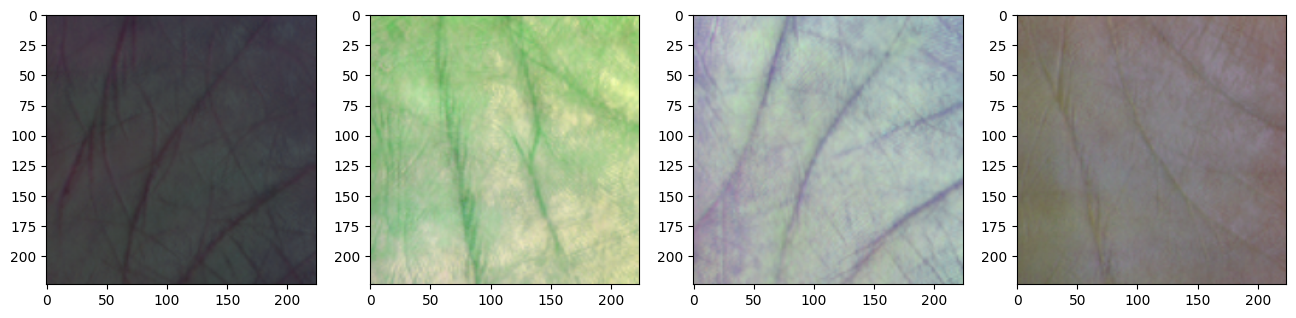

In [16]:
%matplotlib inline
plt.style.use('default')
## show training images
fig, axs = plt.subplots(1, 4, figsize=(16, 8))
images = next(enumerate(trainingDataloader_source))[1][0]
for i in range(4):
    # b,g,r = img.split(3)[0]
    # rgb_img = torch.stack([r,g,b])
    axs[i].imshow(images[i].permute(1, 2, 0).numpy())

# plt.savefig("images/modified_augmentation2.png")
plt.show()
plt.close()

In [23]:
## training: need to initial gallery datset before training
model = model.cuda()
head = head.cuda()
# featureMapping = featureMapping.cuda()
num_epoch = 20
for e in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0
    train_cosine_loss = 0.0
    train_center_loss = 0.0
    norm_max = 0.0
    
    model.train() # 確保 model 是在 train model (開啟 Dropout 等...)
    head.train() # 確保 model 是在 train model (開啟 Dropout 等...)
    # featureMapping.train() # 確保 model 是在 train model (開啟 Dropout 等...)
    for i, (img, labels) in enumerate(trainingDataloader_source):
        inputs = img.cuda()
        labels = labels.cuda()
            
        feats = model(inputs) # output feature embeddings
        margin_output, original_logits = head(feats, labels)
        cosine_loss = criterion["Softmax"](margin_output, labels)
        centerloss = criterion["CenterLoss"](feats, labels, head.weight) * criterion["Lambda"]
        batch_loss = cosine_loss+centerloss
        _, train_pred = torch.max(original_logits.data, 1)
        
        optimizer.zero_grad() 
        optimzer4center.zero_grad()
        batch_loss.backward() 
        optimizer.step() 
        optimzer4center.step()
        
        train_acc += torch.sum(train_pred == labels).item()
        train_loss += batch_loss.item() * inputs.size(0)
        train_cosine_loss += cosine_loss.item() * inputs.size(0)
        train_center_loss += centerloss.item() * inputs.size(0)
        print("batch loss: {}".format(batch_loss.item()), end="\r")
        
        # max feature norm
        with torch.no_grad():
            norms = feats.norm(dim=-1)
            norm_max = norms.max().item() if norms.max() > norm_max else norm_max
        
    epoch += 1
    # scheduler.step()
    
    train_acc /=len(trainingDataset_source)
    train_loss /= len(trainingDataset_source)
    train_cosine_loss /= len(trainingDataset_source)
    train_center_loss /= len(trainingDataset_source)
    log_train_acc.append(train_acc)
    log_train_loss.append((train_loss, train_cosine_loss, train_center_loss))
    log_max_feature_norm.append(norm_max)
        
    # calculate norm of gradients
    total_norm = 0.0
    for p in model.parameters():
        if p.requires_grad:
            param_norm = p.grad.data.norm(2).item()
            total_norm += param_norm ** 2
    total_norm = total_norm ** (1. / 2)
    log_gradient_norm.append(total_norm)
    
    model.eval()
    test_loss = 0.0
    gallery_feature_loader = torch.Tensor().cuda()
    gallery_label_loader = torch.Tensor().long()
    probe_feature_loader = torch.Tensor().cuda()
    probe_label_loader = torch.Tensor().long()
    with torch.no_grad():
        for i, (img, labels) in enumerate(galleryDataloader_target):
            inputs = img.cuda()
            feats = model(inputs)
            gallery_feature_loader = torch.cat([gallery_feature_loader, feats], 0)
            gallery_label_loader = torch.cat([gallery_label_loader, labels], 0)

        # calculate centers of each class
        labels = gallery_label_loader.view(gallery_label_loader.size(0), 1).expand(-1, feature_dim).long()
        unique_labels, labels_count = labels.unique(dim=0, return_counts=True)
        centers = torch.zeros([num_classes_target, feature_dim], dtype=torch.float).scatter_add_(0, labels, gallery_feature_loader.cpu()) #[num_classes, feat_dim]
        counts = torch.ones(centers.size(0), dtype=torch.int64) #[num_classes, feat_dim]
        counts[unique_labels[:,0]] = labels_count
        centers = centers / counts.unsqueeze(1) # divide by label counts

        for i, (img, labels) in enumerate(probeDataloader_target):
            inputs = img.cuda()
            feats = model(inputs)
            probe_feature_loader = torch.cat([probe_feature_loader, feats], 0)
            probe_label_loader = torch.cat([probe_label_loader, labels], 0)

        centers = centers.cuda()
        probe_label_loader = probe_label_loader.cuda()
        logits = head.classify(probe_feature_loader, centers)     
        cosine_loss = nn.CrossEntropyLoss()(logits, probe_label_loader).item()
        center_loss = CenterLoss()(probe_feature_loader, probe_label_loader, centers).item() * 0.1
        # cosine_loss = criterion["Softmax"](logits, probe_label_loader).item()
        # center_loss = criterion["CenterLoss"](probe_feature_loader, probe_label_loader, centers).item() * criterion["Lambda"]

    log_test_loss.append((cosine_loss+center_loss, cosine_loss, center_loss))
    cos = nn.CosineSimilarity()
    test_acc = 0.0
    for i,p in enumerate(probe_feature_loader):
        cosine = cos(p, gallery_feature_loader)
        test_pred = torch.max(cosine, 0).indices.item()
        test_acc += gallery_label_loader[test_pred] == probe_label_loader[i]
    test_acc /= len(probe_feature_loader)
    log_test_acc.append(test_acc.item())
    
    l = '[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f test Acc: %3.6f norm of gradient: %3.6f' % \
        (epoch, num_epoch, time.time()-epoch_start_time, train_acc, train_loss, test_acc, total_norm)
    print(l)
    
    if epoch % 10 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'head_state_dict': head.state_dict(),
            # 'optimizer_state_dict': optimizer.state_dict(),
            # 'optimzer4center_state_dict': optimzer4center.state_dict(),
            'criterion': criterion,
            'training_class_indices': training_class_indices_source,
            'testing_class_indices': testing_class_indices_source,
            'trainingTransform': trainingTransform,
            'testingTransform': testingTransform
        }, "model/{}-{}e-optuna-third.pt".format(prefix, epoch))

[002/002] 40.03 sec(s) Train Acc: 0.010185 Loss: 26.746831 test Acc: 0.191000 norm of gradient: 14.213043
[003/002] 38.32 sec(s) Train Acc: 0.200000 Loss: 24.130438 test Acc: 0.497667 norm of gradient: 46.241012


In [554]:
log_test_loss

[(4.377110493183136, 4.329819202423096, 0.04729129076004029),
 (2.8307965993881226, 2.499969482421875, 0.33082711696624756),
 (0.2504912048578262, 0.1965673416852951, 0.05392386317253113),
 (0.08421281427145005, 0.03576000779867172, 0.048452806472778324),
 (0.057781656831502916, 0.02164643630385399, 0.03613522052764893),
 (0.03609126638621092, 0.008752266876399517, 0.027338999509811404),
 (0.06729543656110763, 0.0374971404671669, 0.029798296093940736),
 (0.048978489264845854, 0.026012307032942772, 0.022966182231903078),
 (0.037219437584280965, 0.014335079118609428, 0.02288435846567154),
 (0.03527089692652226, 0.011672722175717354, 0.023598174750804904),
 (0.040291573852300644, 0.017107028514146805, 0.02318454533815384),
 (0.04884069040417671, 0.02723626419901848, 0.021604426205158234),
 (0.06036262661218643, 0.03953494876623154, 0.020827677845954896),
 (0.04121867865324021, 0.017403103411197662, 0.023815575242042544),
 (0.042868273332715034, 0.020540961995720863, 0.02232731133699417),


In [817]:
log_loader = []

In [822]:
log_loader.append({
    "log_train_loss":log_train_loss,
    "log_test_loss":log_test_loss,
    "log_train_acc":log_train_acc,
    "log_test_acc":log_test_acc,
    "log_gradient_norm":log_gradient_norm,
    "log_max_feature_norm":log_max_feature_norm,
})
len(log_loader)

3

In [557]:
torch.save(log_loader, "plot/{}-{}e-train-optuna-third.pt".format(prefix, epoch))

In [24]:
## load log
checkpoint = torch.load("plot/PolyU-5s-Reduced_ResNeSt50d_pretrained-128emb-LMCL-Focal+Huber-1l-0.001lr-0.9mm-0l2-20e-train-optuna-third.pt")[0]
log_train_loss = checkpoint['log_train_loss']
log_test_loss = checkpoint['log_test_loss']
log_train_acc = checkpoint['log_train_acc']
log_test_acc = checkpoint['log_test_acc']
log_gradient_norm = checkpoint['log_gradient_norm']
log_max_feature_norm = checkpoint['log_max_feature_norm']
# log_loader = []

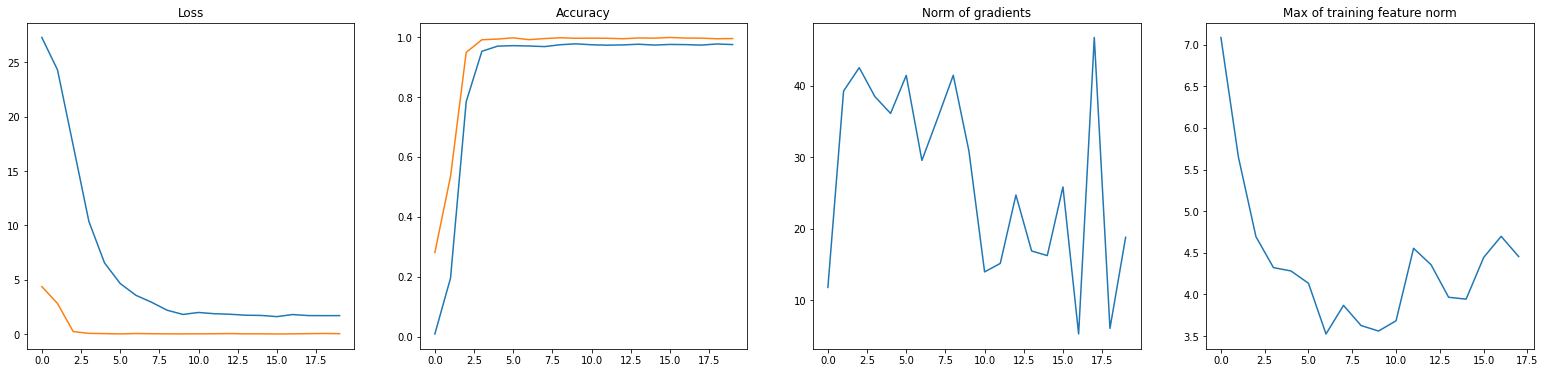

In [558]:
## training curve
%matplotlib inline

# training_record = (log_loss, log_acc, log_test_acc, log_gradient_norm)
fig, axs = plt.subplots(1, 4, figsize=(27, 6))
# axs[0].plot(log_train_loss)
axs[0].plot([loss[0] for loss in log_train_loss])
axs[0].plot([loss[0] for loss in log_test_loss])
# axs[0].plot([loss[1] for loss in log_test_loss])
# axs[0].set_ylim([0,2])
axs[0].set_title("Loss")
axs[1].plot(log_train_acc)
# axs[1].plot(log_val_acc)
axs[1].plot(log_test_acc)
axs[1].set_title("Accuracy")
axs[2].plot(log_gradient_norm)
axs[2].set_title("Norm of gradients")
axs[3].plot(log_max_feature_norm[2:])
axs[3].set_title("Max of training feature norm")
plt.savefig('plot/{}-{}e-train-optuna-third.jpg'.format(prefix, epoch))
plt.show()

# torch.save({
#     "log_train_loss":log_train_loss,
#     "log_test_loss":log_test_loss,
#     "log_train_acc":log_train_acc,
#     "log_test_acc":log_test_acc,
#     "log_gradient_norm":log_gradient_norm,
#     "log_max_feature_norm":log_max_feature_norm,
# }, "plot/{}-{}e-train.pt".format(prefix, epoch))

In [263]:
## load model
checkpoint = torch.load("model/PolyU-optuna-third-5s-Reduced_ResNeSt50d_pretrained-128emb-LMCL-Focal+Huber-1l-0.001lr-0.9mm-0l2-20e.pt")
epoch = checkpoint['epoch']
model.load_state_dict(checkpoint['model_state_dict'])
head.load_state_dict(checkpoint['head_state_dict'])
criterion = checkpoint['criterion']
training_class_indices = checkpoint['training_class_indices']
testing_class_indices = checkpoint['testing_class_indices']
trainingTransform = checkpoint['trainingTransform']
testingTransform = checkpoint['testingTransform']


In [32]:
## test training acc and plot features
train_acc = 0.0
feature_loader = torch.Tensor().cuda()
label_loader = torch.Tensor().cuda()
model= model.cuda()
head= head.cuda()
model.eval()
if hasattr(criterion, "easy_margin"):
    criterion.easy_margin = True
with torch.no_grad():
    for i, (img, labels) in enumerate(validationDataloader_source):
        inputs = img.cuda()
        labels = labels.cuda()
        feats = model(inputs)
        margin_output, original_logits = head(feats, labels)
        
        _, train_pred = torch.max(original_logits, 1)
        train_acc += torch.sum(train_pred == labels)
        feature_loader = torch.cat([feature_loader, feats], 0)
        label_loader = torch.cat([label_loader, labels], 0)
        
    norms = feature_loader.norm(dim=1).cpu()
    norm_max = norms.max().ceil()
    norm_min = norms.min().floor()
    print("Train Acc: %3.6f" % (train_acc/len(trainingDataset_source)))
    print("max norm: %d, min norm: %d" % (norm_max, norm_min))

Train Acc: 1.000000
max norm: 6, min norm: 1


In [28]:
## load model
checkpoint = torch.load("model/PolyU-optuna-third-5s-Reduced_ResNeSt50d_pretrained-128emb-LMCL-Focal+Huber-1l-0.001lr-0.9mm-0l2-20e.pt")
epoch = checkpoint['epoch']
model.load_state_dict(checkpoint['model_state_dict'])
head.load_state_dict(checkpoint['head_state_dict'])
criterion = checkpoint['criterion']
training_class_indices = checkpoint['training_class_indices']
testing_class_indices = checkpoint['testing_class_indices']
trainingTransform = checkpoint['trainingTransform']
testingTransform = checkpoint['testingTransform']


In [29]:
val_ratio = 0
(trainingDataset_source, 
 validationDataset_source, 
 galleryDataset_source, 
 probeDataset_source, 
 training_class_indices_source, 
 testing_class_indices_source) = buildDatasets(
    dataset, shot, val_ratio, test_ratio, (training_class_indices, testing_class_indices))
trainingDataloader_source, validationDataloader_source, galleryDataloader_source, probeDataloader_source = buildDataloaders(
    trainingDataset_source, validationDataset_source, galleryDataset_source, probeDataset_source, batch_size_train = 32, batch_size_test = 128)
print("------ source dataset parameters ------")
print("training classes: ", len(training_class_indices_source))
print("testing classes: ", len(testing_class_indices_source))
print("training samples: ", len(trainingDataset_source))
print("validation samples: ", len(validationDataset_source))
print("gallery samples: ", len(galleryDataset_source))
print("probe samples: ", len(probeDataset_source))

------ source dataset parameters ------
training classes:  450
testing classes:  50
training samples:  5400
validation samples:  5400
gallery samples:  250
probe samples:  350


In [30]:
## target dataset parameters
dataset_choices = ["PolyU","Tongji","MPD_h","MPD_m"]
dataset_target = dataset_choices[2]
val_ratio = 0
test_ratio = 0
shot = 5
num_classes_target = dataset_params[dataset_target][1]*2 if dataset_target.startswith("MPD") else dataset_params[dataset_target][1]

print("------ dataset parameters ------")
print("dataset: ", dataset_target)
print("val ratio: ", val_ratio)
print("test ratio: ", test_ratio)
print("number of shots: ", shot)

(trainingDataset_target, 
validationDataset_target, 
galleryDataset_target, 
probeDataset_target, 
training_class_indices_target, 
testing_class_indices_target) = buildDatasets(dataset_target, shot, val_ratio, test_ratio)
trainingDataloader_target, validationDataloader_target, galleryDataloader_target, probeDataloader_target = buildDataloaders(
    trainingDataset_target, validationDataset_target, galleryDataset_target, probeDataset_target, batch_size_train = 32, batch_size_test = 128)
print("------ target dataset parameters ------")
print("training classes: ", len(training_class_indices_target))
print("testing classes: ", len(testing_class_indices_target))
print("training samples: ", len(trainingDataset_target))
print("validation samples: ", len(validationDataset_target))
print("gallery samples: ", len(galleryDataset_target))
print("probe samples: ", len(probeDataset_target))

print("------ end dataset parameters ------")

------ dataset parameters ------
dataset:  MPD_h
val ratio:  0
test ratio:  0
number of shots:  5
------ target dataset parameters ------
training classes:  200
testing classes:  200
training samples:  8000
validation samples:  8000
gallery samples:  2000
probe samples:  6000
------ end dataset parameters ------


In [31]:
# calculate target test acc with mirror
model= model.cuda()
model.eval()
gallery_feature_loader = torch.Tensor().cuda()
gallery_label_loader = torch.Tensor().long()
probe_feature_loader = torch.Tensor().cuda()
probe_label_loader = torch.Tensor().long()
with torch.no_grad():
    for i, (img, labels) in enumerate(galleryDataloader_target):
        inputs = img.cuda()
        feats = model(inputs)
        
        # inputs_mirror = torch.fliplr(img).cuda()
        inputs_mirror = torch.flip(img, (-2,)).cuda()
        feats_mirror = model(inputs_mirror)
        feats = torch.cat([feats, feats_mirror], 1)
        
        gallery_feature_loader = torch.cat([gallery_feature_loader, feats], 0)
        gallery_label_loader = torch.cat([gallery_label_loader, labels], 0)
    

    for i, (img, labels) in enumerate(probeDataloader_target):
        inputs = img.cuda()
        feats = model(inputs)
        
        inputs_mirror = torch.flip(img, (-2,)).cuda()
        feats_mirror = model(inputs_mirror)
        # feats =  feats_mirror
        feats = torch.cat([feats, feats_mirror], 1)
        
        probe_feature_loader = torch.cat([probe_feature_loader, feats], 0)
        probe_label_loader = torch.cat([probe_label_loader, labels], 0)
   

match_scores = torch.Tensor()
mathces = torch.Tensor()
probe_label_loader = probe_label_loader.cpu()
cos = nn.CosineSimilarity()
test_acc = 0.0
fail = 0
fail_loader = []
for i,p in enumerate(probe_feature_loader):
    cosine = cos(p, gallery_feature_loader)
    test_pred = torch.max(cosine, 0).indices.item()
    test_acc += gallery_label_loader[test_pred] == probe_label_loader[i]
    if gallery_label_loader[test_pred] != probe_label_loader[i]:
        true_indexes = np.where(gallery_label_loader == probe_label_loader[i])
        fail_loader.append([test_pred, i, cosine[test_pred].item(), cosine[true_indexes].cpu()])

    # open-set verification: match scores for every gallery entry to every probe input
    # match_scores = torch.cat([match_scores, cosine.cpu()], 0)
    # mathces = torch.cat([mathces, (probe_label_loader[i] == gallery_label_loader)], 0)
    
test_acc /= len(probe_feature_loader)
print("Test Acc: %3.6f" % (test_acc))
print(len(fail_loader))

Test Acc: 0.900500
597


In [702]:
# calculate test acc with mirrors
model= model.cuda()
model.eval()
gallery_feature_loader = torch.Tensor().cuda()
gallery_label_loader = torch.Tensor()
probe_feature_loader = torch.Tensor().cuda()
probe_label_loader = torch.Tensor()
with torch.no_grad():
    for i, (img, labels) in enumerate(galleryDataloader_target):
        images = []
        images.append(img.cuda()) # original
        images.append(torch.flip(img, (-1,)).cuda()) # horizantal
        images.append(torch.flip(img, (-2,)).cuda()) # vertical
        # images.append(torch.flip(img, (-1,-2)).cuda()) # h+v = 180 degree
        images.append(torch.rot90(img, 1, (-1,-2)).cuda()) # 90 degree
        images.append(torch.rot90(img, 3, (-1,-2)).cuda()) # 270 degree

        feats = []
        for image in images:
            feats.append(model(image))
        feats = torch.stack(feats, dim=1)
        
        gallery_feature_loader = torch.cat([gallery_feature_loader, feats], 0)
        gallery_label_loader = torch.cat([gallery_label_loader, labels], 0)
    for i, (img, labels) in enumerate(probeDataloader_target):
        images = []
        images.append(img.cuda()) # original
        images.append(torch.flip(img, (-1,)).cuda()) # horizantal
        images.append(torch.flip(img, (-2,)).cuda()) # vertical
        # images.append(torch.flip(img, (-1,-2)).cuda()) # h+v = 180 degree
        images.append(torch.rot90(img, 1, (-1,-2)).cuda()) # 90 degree
        images.append(torch.rot90(img, 3, (-1,-2)).cuda()) # 270 degree

        feats = []
        for image in images:
            feats.append(model(image))
        feats = torch.stack(feats, dim=1)
        
        probe_feature_loader = torch.cat([probe_feature_loader, feats], 0)
        probe_label_loader = torch.cat([probe_label_loader, labels], 0)

match_scores = torch.Tensor()
mathces = torch.Tensor()
cos = nn.CosineSimilarity(dim=-1)
test_acc = 0.0
fail = 0
fail_loader = []
for i,p in enumerate(probe_feature_loader):
    cosine = cos(p, gallery_feature_loader)
    
    # average all transformation type
    similarity_mean = cosine.sum(dim=-1) / (cosine!=0).sum(1)
    
    test_pred = torch.max(similarity_mean, 0).indices.item()
    test_acc += gallery_label_loader[test_pred] == probe_label_loader[i]
    
    if gallery_label_loader[test_pred] != probe_label_loader[i]:
        true_indexes = np.where(gallery_label_loader == probe_label_loader[i])
        fail_loader.append([test_pred, i, cosine[test_pred].cpu(), cosine[true_indexes].cpu()])
        
    # open-set verification: match scores for every gallery entry to every probe input
    # match_scores = torch.cat([match_scores, similarity_mean.cpu()], 0)
    # mathces = torch.cat([mathces, (probe_label_loader[i] == gallery_label_loader)], 0)
    
test_acc /= len(probe_feature_loader)
print("Test Acc: %3.6f" % (test_acc))
print("Number of disabled gallery mirror template: %d" % ((gallery_feature_loader.norm(dim=-1) == 0).sum()))
print("Number of disabled probe mirror template: %d" % ((probe_feature_loader.norm(dim=-1) == 0).sum()))
print("Number of failed: %d" % (len(fail_loader)))

Test Acc: 0.940667
Number of disabled gallery mirror template: 0
Number of disabled probe mirror template: 0
Number of failed: 356


In [472]:
print(fail_loader[1])
print(gallery_label_loader[fail_loader[0][0]], probe_label_loader[fail_loader[0][1]])


[tensor(406, device='cuda:0'), 22, tensor(0.6359, device='cuda:0'), tensor([0.5847, 0.6338, 0.6024, 0.6092, 0.6068], device='cuda:0')]
tensor(169.) tensor(1.)


In [ ]:
## testing

In [19]:
## load model
checkpoint = torch.load("model/PolyU-5s-ResNet20_basic-128emb-LMCL-Focal+Huber-1l-0.001lr-0.9mm-0l2-20e.pt")
epoch = checkpoint['epoch']
model.load_state_dict(checkpoint['model_state_dict'])
head.load_state_dict(checkpoint['head_state_dict'])
criterion = checkpoint['criterion']
training_class_indices = checkpoint['training_class_indices']
testing_class_indices = checkpoint['testing_class_indices']
trainingTransform = checkpoint['trainingTransform']
testingTransform = checkpoint['testingTransform']

In [12]:
## target dataset parameters
dataset_choices = ["PolyU","Tongji","MPD_h","MPD_m","PolyU_JPG","Tongji_JPG"]
dataset_target = dataset_choices[2]
val_ratio = 0
test_ratio = 0.5
shot = 5
num_classes_target = dataset_params[dataset_target][1]*2 if dataset_target.startswith("MPD") else dataset_params[dataset_target][1]

print("------ dataset parameters ------")
print("dataset: ", dataset_target)
print("val ratio: ", val_ratio)
print("test ratio: ", test_ratio)
print("number of shots: ", shot)

(trainingDataset_target, 
validationDataset_target, 
galleryDataset_target, 
probeDataset_target, 
training_class_indices_target, 
testing_class_indices_target) = buildDatasets(dataset_target, shot, val_ratio, test_ratio)
trainingDataloader_target, validationDataloader_target, galleryDataloader_target, probeDataloader_target = buildDataloaders(
    trainingDataset_target, validationDataset_target, galleryDataset_target, probeDataset_target, batch_size_train = 32, batch_size_test = 128)
print("------ target dataset parameters ------")
print("training classes: ", len(training_class_indices_target))
print("testing classes: ", len(testing_class_indices_target))
print("training samples: ", len(trainingDataset_target))
print("validation samples: ", len(validationDataset_target))
print("gallery samples: ", len(galleryDataset_target))
print("probe samples: ", len(probeDataset_target))

print("------ end dataset parameters ------")

------ dataset parameters ------
dataset:  MPD_h
val ratio:  0
test ratio:  0.5
number of shots:  5
------ target dataset parameters ------
training classes:  100
testing classes:  100
training samples:  4000
validation samples:  4000
gallery samples:  1000
probe samples:  3000
------ end dataset parameters ------


In [ ]:
## get feature embedding concat with mirror image
model.eval()
gallery_feature_loader = torch.Tensor().cuda()
gallery_label_loader = torch.Tensor()
probe_feature_loader = torch.Tensor().cuda()
probe_label_loader = torch.Tensor()
with torch.no_grad():
    for i, (img, labels) in enumerate(galleryDataloader_target):
        inputs = img.cuda()
        feats = model(inputs)
        
        inputs_mirror = torch.fliplr(img).cuda()
        feats_mirror = model(inputs_mirror)
        feats = torch.cat([feats, feats_mirror], 1)
        
        gallery_feature_loader = torch.cat([gallery_feature_loader, feats], 0)
        gallery_label_loader = torch.cat([gallery_label_loader, labels], 0)
    for i, (img, labels) in enumerate(probeDataloader_target):
        inputs = img.cuda()
        feats = model(inputs)
        
        inputs_mirror = torch.fliplr(img).cuda()
        feats_mirror = model(inputs_mirror)
        feats = torch.cat([feats, feats_mirror], 1)
        
        probe_feature_loader = torch.cat([probe_feature_loader, feats], 0)
        probe_label_loader = torch.cat([probe_label_loader, labels], 0)
len(gallery_feature_loader), len(gallery_label_loader), len(probe_feature_loader), len(probe_label_loader)

In [20]:
## verification: normal version
model = model.cuda()
model.eval()
# criterion.eval()
test_loss = 0.0
gallery_feature_loader = torch.Tensor().cuda()
gallery_label_loader = torch.Tensor().long()
probe_feature_loader = torch.Tensor().cuda()
probe_label_loader = torch.Tensor().long()
with torch.no_grad():
    for i, (img, labels) in enumerate(galleryDataloader_target):
        inputs = img.cuda()
        feats = model(inputs)
        gallery_feature_loader = torch.cat([gallery_feature_loader, feats], 0)
        gallery_label_loader = torch.cat([gallery_label_loader, labels], 0)    
    for i, (img, labels) in enumerate(probeDataloader_target):
        inputs = img.cuda()
        feats = model(inputs)
        probe_feature_loader = torch.cat([probe_feature_loader, feats], 0)
        probe_label_loader = torch.cat([probe_label_loader, labels], 0)

# test_loss = test_loss/(len(galleryDataset) + len(probeDataset))
# print("Test loss: ", test_loss)
len(gallery_feature_loader), len(gallery_label_loader), len(probe_feature_loader), len(probe_label_loader)

(1000, 1000, 3000, 3000)

In [159]:
## verification: normal version
model = model.cuda()
head = head.cuda()
model.eval()
# criterion.eval()
test_loss = 0.0
gallery_feature_loader = torch.Tensor().cuda()
gallery_label_loader = torch.Tensor().long()
probe_feature_loader = torch.Tensor().cuda()
probe_label_loader = torch.Tensor().long()
with torch.no_grad():
    for i, (img, labels) in enumerate(galleryDataloader_target):
        inputs = img.cuda()
        feats = model(inputs)
        gallery_feature_loader = torch.cat([gallery_feature_loader, feats], 0)
        gallery_label_loader = torch.cat([gallery_label_loader, labels], 0)
    
    # calculate centers of each class
    labels = gallery_label_loader.view(gallery_label_loader.size(0), 1).expand(-1, feature_dim).long()
    unique_labels, labels_count = labels.unique(dim=0, return_counts=True)
    centers = torch.zeros([num_classes_target, feature_dim], dtype=torch.float).scatter_add_(0, labels, gallery_feature_loader.cpu()) #[num_classes, feat_dim]
    counts = torch.ones(centers.size(0), dtype=torch.int64) #[num_classes, feat_dim]
    counts[unique_labels[:,0]] = labels_count
    centers = centers / counts.unsqueeze(1) # divide by label counts
    
    for i, (img, labels) in enumerate(probeDataloader_target):
        inputs = img.cuda()
        feats = model(inputs)
        probe_feature_loader = torch.cat([probe_feature_loader, feats], 0)
        probe_label_loader = torch.cat([probe_label_loader, labels], 0)
   
    centers = centers.cuda()
    probe_label_loader = probe_label_loader.cuda()
    logits = head.classify(probe_feature_loader, centers)     
    cosine_loss = nn.CrossEntropyLoss()(logits, probe_label_loader).item()
    # cosine_loss = criterion["Softmax"](logits, probe_label_loader).item()
    center_loss = CenterLoss()(probe_feature_loader, probe_label_loader, centers).item() * 0.1
    # center_loss = criterion["CenterLoss"](probe_feature_loader, probe_label_loader, centers).item() * criterion["Lambda"]

# test_loss = test_loss/(len(galleryDataset) + len(probeDataset))
# print("Test loss: ", test_loss)
print("Cosine loss: ", cosine_loss)
print("Center loss: ", center_loss)
len(gallery_feature_loader), len(gallery_label_loader), len(probe_feature_loader), len(probe_label_loader)

Cosine loss:  0.9003767371177673
Center loss:  0.050689983367919925


(2000, 2000, 6000, 6000)

In [473]:
gallery_feature_loader_total = gallery_feature_loader
gallery_label_loader_total = gallery_label_loader
probe_feature_loader_total = probe_feature_loader
probe_label_loader_total = probe_label_loader

In [290]:
gallery_feature_loader = gallery_feature_loader_total[2500:5500]
gallery_label_loader = gallery_label_loader_total[2500:5500]
probe_feature_loader = probe_feature_loader_total[3500:12500]
probe_label_loader = probe_label_loader_total[3500:12500]

In [472]:
gallery_label_loader[2500:] += 500
gallery_label_loader[5500:] += 600
# gallery_label_loader[7500:] += 400

probe_label_loader[3500:] += 500
probe_label_loader[12500:] += 600
# probe_label_loader[18500:] += 400

gallery_label_loader, probe_label_loader

(tensor([   0,    0,    0,  ..., 1499, 1498, 1499]),
 tensor([   0,    0,    0,  ..., 1499, 1498, 1499]))

In [24]:
from umap import UMAP

# source_embedded = UMAP(n_components=3, n_neighbors=25, min_dist=0.2).fit_transform(gallery_feature_loader.view(-1,128).cpu())
# source_embedded = UMAP(n_components=3, n_neighbors=5, min_dist=0.1).fit_transform(gallery_feature_loader_total.cpu())
source_embedded = UMAP(n_components=3, n_neighbors=5, min_dist=0.1).fit_transform(gallery_feature_loader.cpu())
# source_embedded = UMAP(n_components=3, n_neighbors=10, min_dist=0.1).fit_transform(feature_loader.cpu())
# source_embedded = UMAP(n_components=3, n_neighbors=5, min_dist=0.1).fit_transform(torch.cat([gallery_feature_loader, probe_feature_loader], 0).cpu())
# source_embedded = UMAP(n_components=3, n_neighbors=10, min_dist=0.5).fit_transform(torch.cat([gallery_feature_loader_total, probe_feature_loader_total], 0).cpu())


In [98]:
from sklearn.manifold import TSNE
source_embedded = TSNE(n_components=3).fit_transform(torch.cat([gallery_feature_loader, probe_feature_loader], 0).cpu())
# source_embedded = TSNE(n_components=3).fit_transform(feature_loader.cpu())
# source_embedded = TSNE(n_components=3, perplexity=30).fit_transform(gallery_feature_loader.cpu())
# source_embedded = TSNE(n_components=3).fit_transform(gallery_feature_loader.view(-1,128).cpu())
# source_embedded = TSNE(n_components=3).fit_transform(head.weight[training_class_indices_source].cpu().detach().numpy())


/home/r08942088/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/r08942088/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [217]:
source_embedded_polyu = source_embedded[:2500]
source_embedded_tongji = source_embedded[2500:5500]
source_embedded_mpdh = source_embedded[5500:7500]
source_embedded_mpdm = source_embedded[7500:9500]

In [25]:
# source_embedded_3d_polyu = source_embedded[:2500]
# source_embedded_3d_tongji = source_embedded[2500:5500]
# source_embedded_3d_mpdh = source_embedded[5500:7500]
# source_embedded_3d_mpdm = source_embedded[7500:9500]

source_embedded_3d = source_embedded

# source_embedded_3d_polyu = source_embedded[:2500]
# source_embedded_3d_mpdh = source_embedded[2500:4500]

/tmp/ipykernel_8825/2235274609.py:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


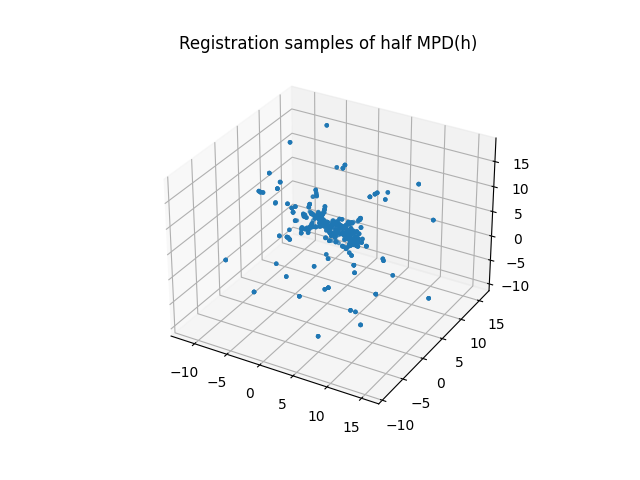

In [26]:
# chap5.2
%matplotlib widget
plt.style.use('default')
# plt.rcParams.update({'font.size': 14})
fig = plt.figure()
ax = fig.gca(projection='3d')

# ax.scatter(source_embedded_3d[1000:, 0], source_embedded_3d[1000:, 1], source_embedded_3d[1000:, 2], marker='.')
ax.scatter(source_embedded_3d[:1000, 0], source_embedded_3d[:1000, 1], source_embedded_3d[:1000, 2], marker='.')

ax.set_title("Registration samples of half MPD(h)")
# ax.legend(["registration sample"])
# ax.view_init(-166, -120)

# plt.scatter(source_embedded[:1000, 0], source_embedded[:1000, 1], marker='.')
# plt.title("Registration samples of half MPD(h)")
# plt.legend(["registration sample"])

plt.savefig("images/resnet20-mpdh-gallery-3d.pdf")
# plt.savefig("images/reduced-resnest50-mpdh-gallery-3d.pdf")
plt.show()

/tmp/ipykernel_395084/3420367063.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


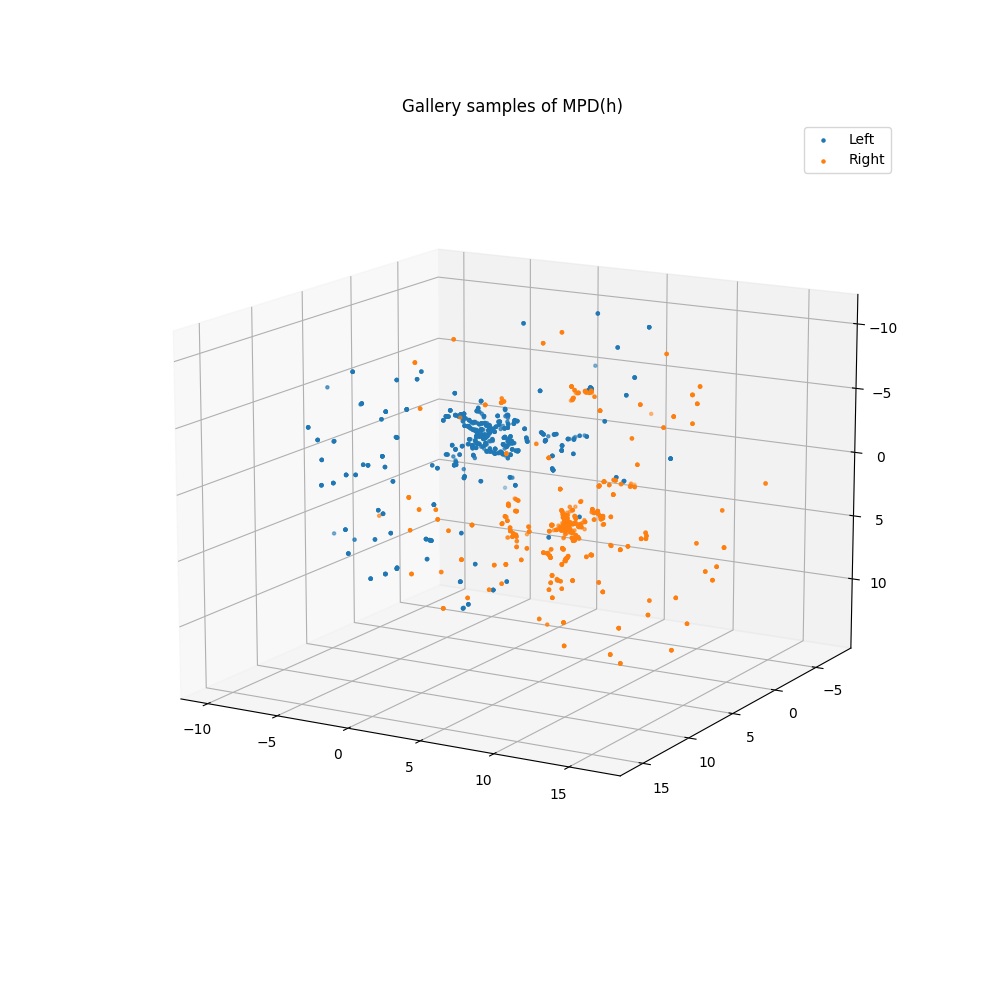

In [565]:
%matplotlib widget
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')

# mpd
# for i in range(400):
#     a = int(i/2)
#     b = i%2
#     start = a*10+b
#     end = a*10+b+10
#     ax.scatter(source_embedded_3d_tongji[start:end:2, 0], source_embedded_3d_tongji[start:end:2, 1], source_embedded_3d_tongji[start:end:2, 2], marker='.')
# left and right
ax.scatter(source_embedded_3d_mpdh[::2, 0], source_embedded_3d_mpdh[::2, 1], source_embedded_3d_mpdh[::2, 2], marker='.')
ax.scatter(source_embedded_3d_mpdh[1::2, 0], source_embedded_3d_mpdh[1::2, 1], source_embedded_3d_mpdh[1::2, 2], marker='.')

# tongji
# for i in range(600):
#     start = i*5
#     end = start+5
#     ax.scatter(source_embedded_3d_tongji[start:end, 0], source_embedded_3d_tongji[start:end, 1], source_embedded_3d_tongji[start:end, 2], marker='.')
ax.legend(["Left", "Right"])
ax.set_title("Gallery samples of MPD(h)")
ax.view_init(-166, -120)
# plt.savefig("images/polyu-baseline-mpdh-gallery.png")

plt.show()

In [83]:
source_embedded_3d.shape

(12000, 3)

/tmp/ipykernel_413986/3733805809.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


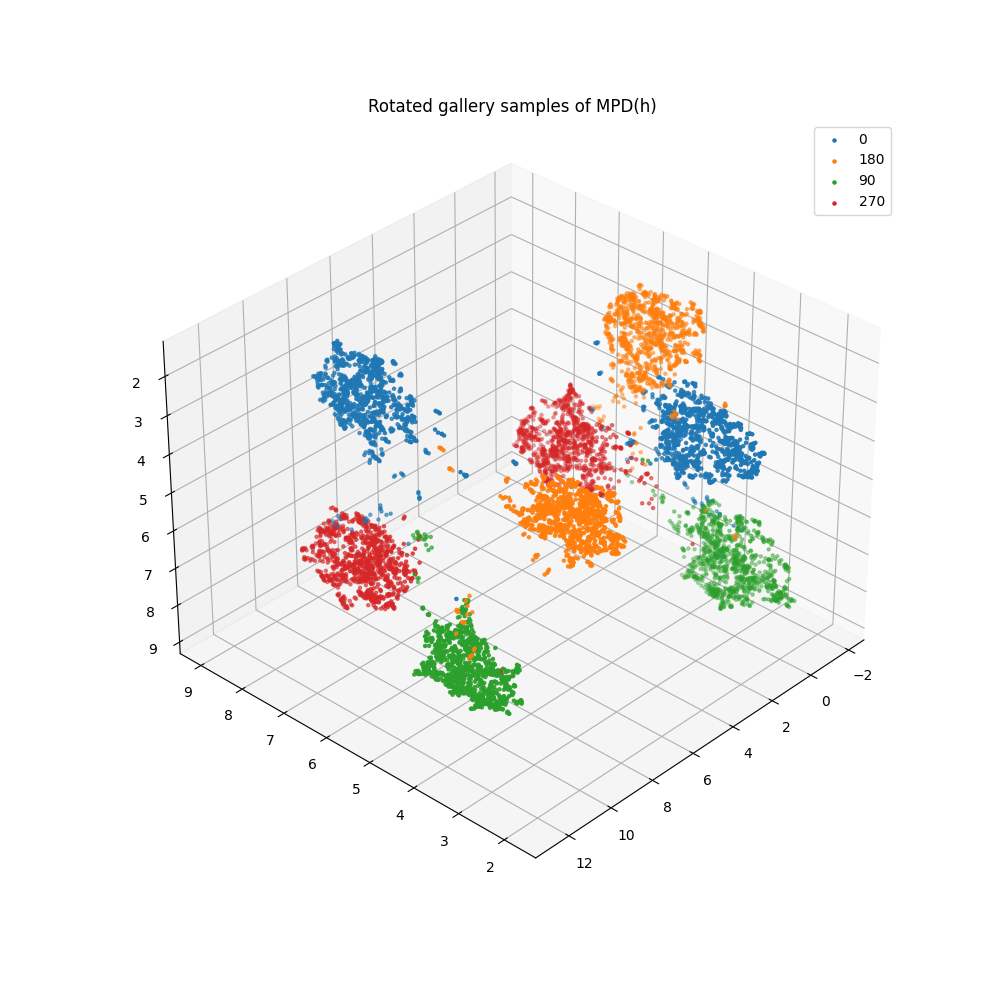

In [170]:
%matplotlib widget
plt.style.use('default')
fig = plt.figure(figsize=(10,10))
color = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff', '#ff00ff',
     '#aa0000', '#aaaa00', '#00aa00', '#00aaaa', '#0000aa', '#aa00aa',
     '#550000', '#555500', '#005500', '#005555', '#000055', '#550055']
ax = fig.gca(projection='3d')
# ax.scatter(source_embedded_3d_polyu[:, 0], source_embedded_3d_polyu[:, 1], source_embedded_3d_polyu[:, 2], marker='.')
# ax.scatter(source_embedded_3d_tongji[:, 0], source_embedded_3d_tongji[:, 1], source_embedded_3d_tongji[:, 2], marker='.')
# ax.scatter(source_embedded_3d_mpdh[:, 0], source_embedded_3d_mpdh[:, 1], source_embedded_3d_mpdh[:, 2], marker='.')
# ax.scatter(source_embedded_3d_mpdm[:, 0], source_embedded_3d_mpdm[:, 1], source_embedded_3d_mpdm[:, 2], marker='.')

# ax.scatter(source_embedded_3d[:, 0], source_embedded_3d[:, 1], source_embedded_3d[:, 2], marker='.')

# UMAP
# fail_index = [2000+f[1] for f in fail_loader]
# true_index = np.ones(source_embedded_3d.shape[0], dtype=bool)
# true_index[fail_index] = False
# ax.scatter(source_embedded_3d[true_index][:, 0], source_embedded_3d[true_index][:, 1], source_embedded_3d[true_index][:, 2], marker='.')
# ax.scatter(source_embedded_3d[fail_index][:, 0], source_embedded_3d[fail_index][:, 1], source_embedded_3d[fail_index][:, 2], marker='.')
# ax.legend(["True", "False"])

# ax.scatter(source_embedded_3d[::2, 0], source_embedded_3d[::2, 1], source_embedded_3d[::2, 2], marker='.')
# ax.scatter(source_embedded_3d[1::2, 0], source_embedded_3d[1::2, 1], source_embedded_3d[1::2, 2], marker='.')
# ax.legend(["Left", "Right"])

temp = source_embedded_3d.reshape(2000, 4, -1).transpose(1,0,2)
# ax.scatter(temp[1, :, 0], temp[1, :, 1], temp[1, :, 2], marker='.')

# source_embedded_3d_mpdh = temp[3].reshape(-1,3)
# ax.scatter(source_embedded_3d_mpdh[::2, 0], source_embedded_3d_mpdh[::2, 1], source_embedded_3d_mpdh[::2, 2], marker='.', c="blue")
# ax.scatter(source_embedded_3d_mpdh[1::2, 0], source_embedded_3d_mpdh[1::2, 1], source_embedded_3d_mpdh[1::2, 2], marker='.', c="orange")

# source_embedded_3d_mpdh = temp[2].reshape(-1,3)
# ax.scatter(source_embedded_3d_mpdh[::2, 0], source_embedded_3d_mpdh[::2, 1], source_embedded_3d_mpdh[::2, 2], marker='.', c="orange")
# ax.scatter(source_embedded_3d_mpdh[1::2, 0], source_embedded_3d_mpdh[1::2, 1], source_embedded_3d_mpdh[1::2, 2], marker='.', c="blue")

# source_embedded_3d_mpdh = temp[:]
# for i,s in enumerate(source_embedded_3d_mpdh):
#     ax.scatter(s[::2, 0], s[::2, 1], s[::2, 2], marker='.')
#     ax.scatter(s[1::2, 0], s[1::2, 1], s[1::2, 2], marker='.')

for t in temp:
    ax.scatter(t[:, 0], t[:, 1], t[:, 2], marker='.')
ax.legend(["0", "180", "90", "270"])

# ax.legend(["PolyU", "Tongji", "MPD(h)", "MPD(m)"])
ax.set_title("Rotated gallery samples of MPD(h)")
# ax.set_title("Cross-subject samples")
ax.view_init(-147, 137)
# plt.savefig("images/polyu-color-Huber-mpdh-all-fail-UMAP.png")
plt.savefig("images/polyu_king_rotated_gallery_samples_UMAP.png")
plt.show()

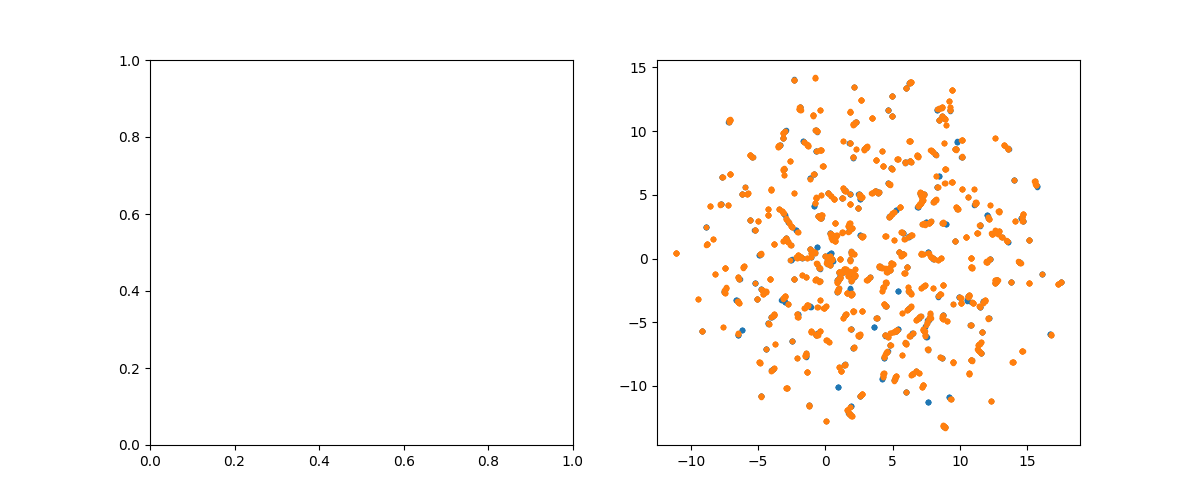

In [88]:
plt.style.use('default')
fig, ax = plt.subplots(1,2, figsize=(12,5))
c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff', '#ff00ff',
     '#aa0000', '#aaaa00', '#00aa00', '#00aaaa', '#0000aa', '#aa00aa',
     '#550000', '#555500', '#005500', '#005555', '#000055', '#550055']
sample_classes = 18
samples_of_class = 5

# for i in range(sample_classes):
#     ax[0].plot(source_embedded[i*samples_of_class:(i+1)*samples_of_class, 0], source_embedded[i*samples_of_class:(i+1)*samples_of_class, 1], '.', c=c[i])

# plt.scatter(source_embedded_polyu[:, 0], source_embedded_polyu[:, 1], marker='.')
# plt.scatter(source_embedded_tongji[:, 0], source_embedded_tongji[:, 1], marker='.')
# plt.scatter(source_embedded_mpdm[:, 0], source_embedded_mpdm[:, 1], marker='.')
# plt.scatter(source_embedded_mpdh[:, 0], source_embedded_mpdh[:, 1], marker='.')
plt.scatter(source_embedded[:1000, 0], source_embedded[:1000, 1], marker='.')
plt.scatter(source_embedded[1000:, 0], source_embedded[1000:, 1], marker='.')
plt.show()

In [97]:
## calculate 1 to 1 match score and rank 1 accuracy
match_scores = torch.Tensor()
mathces = torch.Tensor()
# match_scores_rank1 = []
# mathces_rank1 = []
probe_label_loader = probe_label_loader.cpu()
cos = nn.CosineSimilarity()
test_acc = 0.0
# group_acc = 0.0
fail = []
fail_loader = []
for i,p in enumerate(probe_feature_loader):
    cosine = cos(p, gallery_feature_loader)
    test_pred = torch.max(cosine, 0).indices.item()
    test_acc += gallery_label_loader[test_pred] == probe_label_loader[i]
    if gallery_label_loader[test_pred] != probe_label_loader[i]:
        # fail.append(i)
        # fail_index.append(i)
        true_indexes = np.where(gallery_label_loader == probe_label_loader[i])
        fail_loader.append([test_pred, i, cosine[test_pred].item(), cosine[true_indexes].cpu()])
    
    # the group which total score is the gratest
    # group_pred = cosine.view(-1, 6).sum(dim=1).argmax()
    # group_acc += group_pred == probe_label_loader[i]
    
    # open-set verification: match scores for every gallery entry to every probe input
    match_scores = torch.cat([match_scores, cosine.cpu()], 0)
    mathces = torch.cat([mathces, probe_label_loader[i] == gallery_label_loader], 0)
    
    # open-set identification: match scores for rank one gallery entry to every probe input
    # match_scores_rank1.append(cosine_max.cpu())
    # mathces_rank1.append(gallery_label_loader[test_pred] == probe_label_loader[i])
        
test_acc/=len(probe_feature_loader)
print("Test Acc: %3.6f" % (test_acc))
# print("Group Acc: %3.6f" % (group_acc/len(probeDataset)))
print("Fail num: %d" % len(fail_loader))
len(match_scores), len(mathces)#, len(match_scores_rank1), len(mathces_rank1)

Test Acc: 0.872667
Fail num: 382


(3000000, 3000000)

In [127]:
# Euclidean distance
match_scores = torch.Tensor()
mathces = torch.Tensor()
# match_scores_rank1 = []
# mathces_rank1 = []
pdist = nn.PairwiseDistance()
test_acc = 0.0
fail_loader = []
for i,p in enumerate(probe_feature_loader):
    distance = pdist(p, gallery_feature_loader)
    test_pred = torch.min(distance, 0).indices.item()
    test_acc += gallery_label_loader[test_pred] == probe_label_loader[i]
    if gallery_label_loader[test_pred] != probe_label_loader[i]:
        # fail.append(i)
        true_indexes = np.where(gallery_label_loader == probe_label_loader[i])
        fail_loader.append([test_pred, i, cosine[test_pred].item(), cosine[true_indexes].cpu()])
    
    # the group which total score is the gratest
    # group_pred = cosine.view(-1, 6).sum(dim=1).argmax()
    # group_acc += group_pred == probe_label_loader[i]
    
    # open-set verification: match scores for every gallery entry to every probe input
    match_scores = torch.cat([match_scores, cosine.cpu()], 0)
    mathces = torch.cat([mathces, probe_label_loader[i] == gallery_label_loader], 0)
    
    # open-set identification: match scores for rank one gallery entry to every probe input
    # match_scores_rank1.append(cosine_max.cpu())
    # mathces_rank1.append(gallery_label_loader[test_pred] == probe_label_loader[i])
    
    
test_acc/=len(probeDataset_target)
print("Test Acc: %3.6f" % (test_acc))
# print("Group Acc: %3.6f" % (group_acc/len(probeDataset)))
print("Fail num: %d" % len(fail_loader))
len(match_scores), len(mathces)#, len(match_scores_rank1), len(mathces_rank1)

Test Acc: 0.908333
Fail num: 550


(12000000, 12000000)

In [ ]:
## calculate FAR, FRR and EER
from sklearn import metrics
import numpy as np

fpr, tpr, thresholds = metrics.roc_curve(mathces, match_scores, pos_label=1)
fnr = 1-tpr
eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]#, fnr[np.nanargmin(np.absolute((fnr - fpr)))]
print("EER: ", eer)

EER:  0.03881010860484545


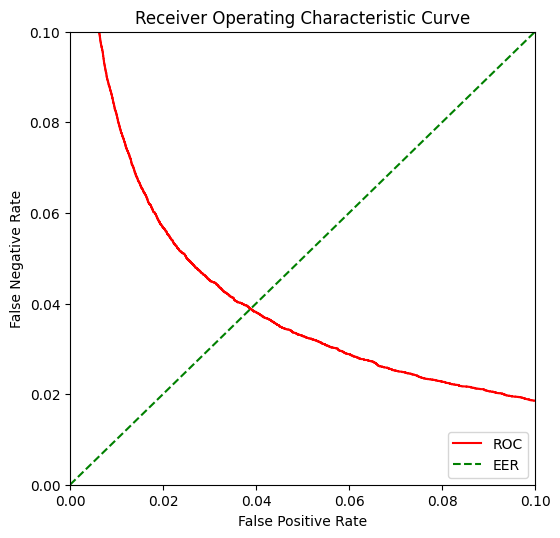

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(6,6), dpi=100)

plt.plot(fpr, fnr, color='red', label='ROC')
plt.plot([0, 1], [0, 1], color='green', label="EER", linestyle='--')
plt.xlim(0,0.1)
plt.ylim(0,0.1)
plt.xlabel('False Positive Rate')
plt.ylabel('False Negative Rate')
# plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend()
# plt.savefig('plot/{}_{}_{}emb_{}l_{}_{}lr_{}e_roc.jpg'.format(dataset, model_type, feature_dim, lamb, loss_func, lr, epoch))
plt.savefig("optuna-third-rotation-ROC-multi.jpg")
plt.show()

In [150]:
## calculate Ver@0.1%FAR and Ver@0.01%FAR
# valid_idx  = np.where(fpr <= 0.001)[0]
threshold_idx_0001 = np.where(fpr <= 0.001)[0].max()
threshold_idx_00001 = np.where(fpr <= 0.0001)[0].max()
print("Verfication TAR at 0.1% FAR: ", tpr[threshold_idx_0001])
print("Verfication TAR at 0.01% FAR: ", tpr[threshold_idx_00001])

Verfication TAR at 0.1% FAR:  0.9468571428571428
Verfication TAR at 0.01% FAR:  0.8778285714285714


In [ ]:
## experiment records: cross dataset
import pandas as pd
df = pd.DataFrame([], columns=["source", "target", "shot", "model", "feature_dim", "Loss function", "lambda", "learning rate", "epoch","source acc","target acc", "mirror acc"])
# ELR
df.loc[0] = ["PolyU", "Tongji", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, '0.001+ELR0.9', 50, 1, 0.7076, 0]
df.loc[1] = ["PolyU", "MPD_h", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, '0.001+ELR0.9', 50, 1, 0.5613, 0]
df.loc[2] = ["PolyU", "MPD_m", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, '0.001+ELR0.9', 50, 1, 0.5915, 0]
df.loc[3] = ["Tongji", "PolyU", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, '0.001+ELR0.9', 50, 0.9533, 0.926, 0]
df.loc[4] = ["Tongji", "MPD_h", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, '0.001+ELR0.9', 50, 0.9533, 0.7288, 0]
df.loc[5] = ["Tongji", "MPD_m", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, '0.001+ELR0.9', 50, 0.9533, 0.7378, 0]
df.loc[6] = ["MPD_h", "PolyU", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, '0.001+ELR0.9', 50, 0.98, 0.8883, 0]
df.loc[7] = ["MPD_h", "Tongji", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, '0.001+ELR0.9', 50, 0.98, 0.8961, 0]
df.loc[8] = ["MPD_h", "MPD_m", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, '0.001+ELR0.9', 50, 0.98, 0.983, 0]
df.loc[9] = ["MPD_m", "PolyU", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, '0.001+ELR0.9', 50, 0.9667, 0.8134, 0]
df.loc[10] = ["MPD_m", "Tongji", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, '0.001+ELR0.9', 50, 0.9667, 0.7903, 0]
df.loc[11] = ["MPD_m", "MPD_h", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, '0.001+ELR0.9', 50, 0.9667, 0.9647, 0]

# reduced 1 resnest50d pretrain lmcl focal huber 
df.loc[0] = ["PolyU", "Tongji", 5, "Reduced_ResNeSt50d_pretrained", 128, "LMCL+focal+huber", 1, 0.001 40, 1, 0.9440, 0.9723]
df.loc[1] = ["PolyU", "MPD_h", 5, "Reduced_ResNeSt50d_pretrained", 128, "LMCL+focal+huber", 1, 0.001, 40, 1, 0.8602, 0.8968]
df.loc[2] = ["PolyU", "MPD_m", 5, "Reduced_ResNeSt50d_pretrained", 128, "LMCL+focal+huber", 1, 0.001, 40, 1, 0.8282, 0.8858]
df.loc[3] = ["Tongji", "PolyU", 5, "Reduced_ResNeSt50d_pretrained", 128, "LMCL+focal+huber", 1, 0.001, 40, 0.99, 0.9834, 0.9951]
df.loc[4] = ["Tongji", "MPD_h", 5, "Reduced_ResNeSt50d_pretrained", 128, "LMCL+focal+huber", 1, 0.001, 40, 0.99, 0.9157, 0.9313]
df.loc[5] = ["Tongji", "MPD_m", 5, "Reduced_ResNeSt50d_pretrained", 128, "LMCL+focal+huber", 1, 0.001, 40, 0.99, 0.9068, 0.9242]
df.loc[6] = ["MPD_h", "PolyU", 5, "Reduced_ResNeSt50d_pretrained", 128, "LMCL+focal+huber", 1, 0.001, 40, 0.985, 0.9637, 0.9951]
df.loc[7] = ["MPD_h", "Tongji", 5, "Reduced_ResNeSt50d_pretrained", 128, "LMCL+focal+huber", 1, 0.001, 40, 0.985, 0.9686, 0.9934]
df.loc[8] = ["MPD_h", "MPD_m", 5, "Reduced_ResNeSt50d_pretrained", 128, "LMCL+focal+huber", 1, 0.001, 40, 0.985, 0.99, 0.9967]
df.loc[9] = ["MPD_m", "PolyU", 5, "Reduced_ResNeSt50d_pretrained", 128, "LMCL+focal+huber", 1, 0.001, 20, 0.9667, 0.9714, 0.9949]
df.loc[10] = ["MPD_m", "Tongji", 5, "Reduced_ResNeSt50d_pretrained", 128, "LMCL+focal+huber", 1, 0.001, 20, 0.9667, 0.9773, 0.9899]
df.loc[11] = ["MPD_m", "MPD_h", 5, "Reduced_ResNeSt50d_pretrained", 128, "LMCL+focal+huber", 1, 0.001, 20, 0.9667, 0.9908, 0.9935]
df

,source,target,shot,model,feature_dim,Loss function,lambda,learning rate,epoch,source acc,target acc
0,PolyU,Tongji,5,ResNeSt26d-pretrained,128,CLMCL,0.1,0.001+ELR0.9,50,1,0.7076
1,PolyU,MPD_h,5,ResNeSt26d-pretrained,128,CLMCL,0.1,0.001+ELR0.9,50,1,0.5613
2,PolyU,MPD_m,5,ResNeSt26d-pretrained,128,CLMCL,0.1,0.001+ELR0.9,50,1,0.5915
3,Tongji,PolyU,5,ResNeSt26d-pretrained,128,CLMCL,0.1,0.001+ELR0.9,50,0.9533,0.9260
4,Tongji,MPD_h,5,ResNeSt26d-pretrained,128,CLMCL,0.1,0.001+ELR0.9,50,0.9533,0.7288
5,Tongji,MPD_m,5,ResNeSt26d-pretrained,128,CLMCL,0.1,0.001+ELR0.9,50,0.9533,0.7378
6,MPD_h,PolyU,5,ResNeSt26d-pretrained,128,CLMCL,0.1,0.001+ELR0.9,50,0.98,0.8883
7,MPD_h,Tongji,5,ResNeSt26d-pretrained,128,CLMCL,0.1,0.001+ELR0.9,50,0.98,0.8961
8,MPD_h,MPD_m,5,ResNeSt26d-pretrained,128,CLMCL,0.1,0.001+ELR0.9,50,0.98,0.9830
9,MPD_m,PolyU,5,ResNeSt26d-pretrained,128,CLMCL,0.1,0.001+ELR0.9,50,0.9667,0.8134


In [269]:
## experiment records: cross dataset fine tuning with new matching
import pandas as pd
df = pd.DataFrame([], columns=["source", "target", "shot", "model", "feature_dim", "Loss function", "lambda", "learning rate", "epoch","source acc","target acc","fine tuning method","fine tuning epoch","source acc","target acc"])
df.loc[0] = ["PolyU", "Tongji", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, 0.001, 20, 1, 0.8217, "all, sum centers", 50, 1, '0.9197(92.46)']
df.loc[1] = ["Tongji", "PolyU", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, 0.001, 10, 0.9833, 0.97, "all, sum centers", 50, 0.9789, '0.9946(99.43)']

# ELR
df.loc[2] = ["PolyU", "Tongji", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, '0.001+ELR0.9', 50, 1, 0.7768, "all, sum centers", 50, 1, '0.915(0.909)']
df.loc[3] = ["Tongji", "PolyU", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, '0.001+ELR0.9', 50, 0.9533, 0.926, "all, sum centers", 50, '0.9578(97.57)', '0.9909(99.43)']
df.loc[4] = ["PolyU", "MPD_h", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, '0.001+ELR0.9', 50, 1, 0.5613, "all, sum centers", 50, 0.9971, 0.8143]
df.loc[5] = ["PolyU", "MPD_m", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, '0.001+ELR0.9', 50, 1, 0.5917, "all, sum centers", 50, 0.9886, 0.7935]
df.loc[6] = ["Tongji", "MPD_h", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, '0.001+ELR0.9', 50, 0.9533, 0.7288, "all, sum centers", 50, 0.9544, 0.8653]
df.loc[7] = ["Tongji", "MPD_m", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, '0.001+ELR0.9', 50, 0.9533, 0.7378, "all, sum centers", 50, 0.9711, 0.8553]
df.loc[7] = ["MPD_h", "PolyU", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, '0.001+ELR0.9', 50, 0.98, 0.8886, "all, sum centers", 50, 0, 0]
df.loc[7] = ["MPD_h", "Tongji", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, '0.001+ELR0.9', 50, 0.98, 0.8961, "all, sum centers", 50, 0, 0]
df.loc[7] = ["MPD_h", "MPD_m", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, '0.001+ELR0.9', 50, 0.98, 0.983, "all, sum centers", 50, 0, 0]
df.loc[7] = ["MPD_m", "PolyU", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, '0.001+ELR0.9', 50, 0.9667, 0.8134, "all, sum centers", 50, 0, 0]
df.loc[7] = ["MPD_m", "Tongji", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, '0.001+ELR0.9', 50, 0.9667, 0.7903, "all, sum centers", 50, 0, 0]
df.loc[7] = ["MPD_m", "MPD_h", 5, "ResNeSt26d-pretrained", 128, "CLMCL", 0.1, '0.001+ELR0.9', 50, 0.9667, 0.9647, "all, sum centers", 50, 0, 0]

df

,source,target,shot,model,feature_dim,Loss function,lambda,learning rate,epoch,source acc,target acc,fine tuning method,fine tuning epoch,source acc,target acc
0,PolyU,Tongji,5,ResNeSt26d-pretrained,128,CLMCL,0.1,0.001,20,1,0.8217,"all, sum centers",50,1,0.9197(92.46)
1,Tongji,PolyU,5,ResNeSt26d-pretrained,128,CLMCL,0.1,0.001,10,0.9833,0.97,"all, sum centers",50,0.9789,0.9946(99.43)
2,PolyU,Tongji,5,ResNeSt26d-pretrained,128,CLMCL,0.1,0.001+ELR0.9,50,1,0.7768,"all, sum centers",50,1,0.915(0.909)
3,Tongji,PolyU,5,ResNeSt26d-pretrained,128,CLMCL,0.1,0.001+ELR0.9,10,0.9689(98.11),0.9426(91.14),"all, sum centers",50,0.9578(97.57),0.9909(99.43)
4,PolyU,MPD_h,5,ResNeSt26d-pretrained,128,CLMCL,0.1,0.001+ELR0.9,50,1,0.5613,"all, sum centers",50,0.9971,0.8143
5,PolyU,MPD_m,5,ResNeSt26d-pretrained,128,CLMCL,0.1,0.001+ELR0.9,50,1,0.5917,"all, sum centers",50,0.9886,0.7935
6,Tongji,MPD_h,5,ResNeSt26d-pretrained,128,CLMCL,0.1,0.001+ELR0.9,50,0.9533,0.7288,"all, sum centers",50,0.9544,0.8653
7,Tongji,MPD_m,5,ResNeSt26d-pretrained,128,CLMCL,0.1,0.001+ELR0.9,50,0.9533,0.7378,"all, sum centers",50,0.9711,0.8553


In [105]:
## experiment records: cross subject feature matching
import pandas as pd
df = pd.DataFrame([], columns=["dataset", "model", "feature_dim", "lambda", "learning rate", "train epoch", "Loss function","identification acc","mirror","mean","half"])
df.loc[0] = ["MPD_h", "ResNet20_basic", 128, 0.1, '0.001', 200, "CLMCL", 0.7733, 0.7267, 0.7983, 0.8133]
df.loc[1] = ["MPD_h", "ResNet18_default", 128, 0.1, '0.001', 150, "CLMCL", 0.9033, 0.9183, 0.8833, 0.9133]
df.loc[2] = ["MPD_h", "ResNeSt26d-pretrained", 128, 0.1, '0.001+ELR', 50, "CLMCL", 0.9667, 0.9533, 0.9783, 0.985]
df.loc[3] = ["MPD_m", "ResNet20_basic", 128, 0.1, '0.001', 200, "CLMCL", 0.86, 0.7017, 0.845, 0.8717]
df.loc[4] = ["MPD_m", "ResNet18_default", 128, 0.1, '0.001', 200, "CLMCL", 0.8483, 0.7733, 0.9017, 0.91]
df.loc[5] = ["MPD_m", "ResNeSt26d-pretrained", 128, 0.1, '0.001+ELR', 50, "CLMCL", 0.98, 0.97, 0.9917, 0.9967]

df

,dataset,model,feature_dim,lambda,learning rate,train epoch,Loss function,identification acc,mirror,mean,half
0,MPD_h,ResNet20_basic,128,0.1,0.001,200,CLMCL,0.7733,0.7267,0.7983,0.8133
1,MPD_h,ResNet18_default,128,0.1,0.001,150,CLMCL,0.9033,0.9183,0.8833,0.9133
2,MPD_h,SE-ResNeXt26d-pretrained,128,0.1,0.001+ELR,50,CLMCL,0.9667,0.9533,0.9783,0.9850
3,MPD_m,ResNet20_basic,128,0.1,0.001,200,CLMCL,0.8600,0.7017,0.8450,0.8717
4,MPD_m,ResNet18_default,128,0.1,0.001,200,CLMCL,0.8483,0.7733,0.9017,0.9100
5,MPD_m,SE-ResNeXt26d-pretrained,128,0.1,0.001+ELR,50,CLMCL,0.9800,0.9700,0.9917,0.9967
